In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from datasets import load_dataset
import numpy as np
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
import math
import matplotlib.pyplot as plt

# Установим random seeds для воспроизводимости
torch.manual_seed(42)
np.random.seed(42)

In [2]:
# --- Гиперпараметры ---
IMAGE_SIZE = 64
PATCH_SIZE = 8
HIDDEN_DIM = 600
VIT_LAYERS = 6
VIT_HEADS = 6
BATCH_SIZE = 128
EPOCHS = 30
NUM_CLASSES = 100
IMAGE_SIZE = 64
BATCH_SIZE = 128
NUM_COMPONENTS = 8  # число компонент смеси в RNADE
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
torch.cuda.is_available()

True

In [4]:
class ToRGB:
    def __call__(self, img):
        return img.convert('RGB')

class TinyImageNetTorch(Dataset):
    def __init__(self, hf_dataset, transform=None):
        self.data = hf_dataset
        self.transform = transform
    def __len__(self):
        return len(self.data)
    def __getitem__(self, index):
        image = self.data[index]['image']
        label = self.data[index]['label']
        if self.transform:
            image = self.transform(image)
        return image, label

def _filter_label_lt_num_classes(example):
    return int(example.get('label', -1)) < NUM_CLASSES

def get_dataset(split: str):
    def load_tinyimagenet(_split):
        dataset = load_dataset('zh-plus/tiny-imagenet', split=_split)
        dataset = dataset.filter(_filter_label_lt_num_classes)
        return dataset

    # Вычисляем статистики для нормализации
    train_raw = load_tinyimagenet('train')
    mean = torch.zeros(3)
    std = torch.zeros(3)
    n_samples = len(train_raw)
    for sample in train_raw:
        img = sample['image']
        img = transforms.ToTensor()(img)
        mean += img.mean(dim=(1, 2))
        std += img.std(dim=(1, 2))
    mean /= n_samples
    std /= n_samples

    raw_dataset = load_tinyimagenet(split)
    if split == 'train':
        tfms = transforms.Compose([
            ToRGB(),
            transforms.RandomResizedCrop(IMAGE_SIZE, scale=(0.8, 1.0)),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize(mean.tolist(), std.tolist()),
        ])
    else:
        tfms = transforms.Compose([
            ToRGB(),
            transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
            transforms.ToTensor(),
            transforms.Normalize(mean.tolist(), std.tolist()),
        ])
    return TinyImageNetTorch(raw_dataset, transform=tfms)

In [5]:
train_ds = get_dataset('train')
val_ds = get_dataset('valid')
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

# Проверка
print(f"Train size: {len(train_ds)}, Val size: {len(val_ds)}")
img, label = train_ds[0]
print(f"Image shape: {img.shape}, Label: {label}")

Train size: 50000, Val size: 5000
Image shape: torch.Size([3, 64, 64]), Label: 0


In [6]:
# --- ViT Backbone ---
class TransformerBlock(nn.Module):
    def __init__(self, hidden_dim, num_heads):
        super().__init__()
        self.attn = nn.MultiheadAttention(hidden_dim, num_heads, batch_first=True)
        self.ln1 = nn.LayerNorm(hidden_dim)
        self.ffn = nn.Sequential(
            nn.Linear(hidden_dim, 4*hidden_dim), nn.GELU(), nn.Linear(4*hidden_dim, hidden_dim)
        )
        self.ln2 = nn.LayerNorm(hidden_dim)
    def forward(self, x, key_padding_mask=None):
        attn_out, _ = self.attn(x, x, x, key_padding_mask=key_padding_mask)
        x = self.ln1(x + attn_out)
        x = self.ln2(x + self.ffn(x))
        return x

class ViTBackbone(nn.Module):
    def __init__(self, image_size, patch_size, hidden_dim, num_layers, num_heads):
        super().__init__()
        self.grid = image_size // patch_size
        self.num_patches = self.grid * self.grid
        self.hidden_dim = hidden_dim
        self.patch_embed = nn.Conv2d(3, hidden_dim, kernel_size=patch_size, stride=patch_size)
        self.pos_embed = nn.Parameter(torch.randn(1, self.num_patches, hidden_dim))
        self.transformer_layers = nn.ModuleList([TransformerBlock(hidden_dim, num_heads) for _ in range(num_layers)])
        self.norm = nn.LayerNorm(hidden_dim)
    def forward(self, x):
        t = self.patch_embed(x)                 # [B, D, g, g]
        t = t.flatten(2).transpose(1, 2)        # [B, T, D]
        t = t + self.pos_embed
        for blk in self.transformer_layers:
            t = blk(t)
        return self.norm(t)                     # [B, T, D]

In [7]:
class ActNorm1D(nn.Module):
    """Data-dependent affine normalization over final dimension (Glow-style)."""
    def __init__(self, dim: int, eps: float = 1e-6):
        super().__init__()
        self.dim = dim
        self.eps = eps
        self.bias = nn.Parameter(torch.zeros(dim))
        self.log_scale = nn.Parameter(torch.zeros(dim))
        # ИСПРАВЛЕНИЕ: используй параметр вместо буфера, чтобы состояние сохранялось
        self.register_buffer('initialized', torch.tensor(0, dtype=torch.uint8))
    
    def initialize(self, x: torch.Tensor):
        flat = x.reshape(-1, self.dim)
        if flat.numel() == 0:
            return
        mean = flat.mean(dim=0)
        std = flat.std(dim=0, unbiased=False).clamp(min=self.eps)
        with torch.no_grad():
            self.bias.copy_(-mean)
            self.log_scale.copy_(torch.log(1.0 / std))
            self.initialized.fill_(1)  # теперь это сохранится
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # ИСПРАВЛЕНИЕ: проверяй initialized == 0, а не bool()
        if self.initialized.item() == 0 and self.training:
            self.initialize(x.detach())
        
        scale = torch.exp(self.log_scale)
        return (x + self.bias) * scale


In [8]:
# --- Student/Teacher ---
class Student(nn.Module):
    def __init__(self, backbone):
        super().__init__()
        self.backbone = backbone
    def encode_context(self, x, context_mask):
        tokens = self.backbone.patch_embed(x).flatten(2).transpose(1, 2)
        pos = self.backbone.pos_embed
        ctx_lists, lengths = [], []
        for i in range(tokens.size(0)):
            idx = context_mask[i].nonzero(as_tuple=False).squeeze(1)
            ti = tokens[i, idx]
            pi = pos[0, idx]
            ctx_lists.append(ti + pi)
            lengths.append(int(idx.numel()))
        Sc = int(max(lengths)) if lengths else 0
        D = tokens.size(2)
        ctx_pad = torch.ones((x.size(0), Sc), dtype=torch.bool, device=x.device)
        ctx_out = torch.zeros((x.size(0), Sc, D), dtype=tokens.dtype, device=x.device)
        for i, ci in enumerate(ctx_lists):
            L = ci.size(0)
            ctx_out[i, :L] = ci
            ctx_pad[i, :L] = False
        for blk in self.backbone.transformer_layers:
            ctx_out = blk(ctx_out, key_padding_mask=ctx_pad)
        ctx_out = self.backbone.norm(ctx_out)
        return ctx_out, ctx_pad

class Teacher(nn.Module):
    def __init__(self, backbone):
        super().__init__()
        self.backbone = backbone
        for p in self.parameters():
            p.requires_grad = False
    @torch.no_grad()
    def forward(self, x):
        return self.backbone(x)
    @torch.no_grad()
    def ema_update(self, student, m):
        for p_t, p_s in zip(self.backbone.parameters(), student.backbone.parameters()):
            p_t.data.mul_(m).add_(p_s.data, alpha=(1.0 - m))

In [9]:
# Маскируемый линейный слой для MADE
class MaskedLinear(nn.Linear):
    def __init__(self, in_features, out_features, mask, bias=True):
        super().__init__(in_features, out_features, bias)
        self.register_buffer('mask', mask)

    def forward(self, input):
        return torch.nn.functional.linear(input, self.weight * self.mask, self.bias)


# Функция для генерации масок в MADE
def create_masks(input_dim, hidden_dims, num_components):
    """
    Генерирует бинарные маски для авторегрессионного MLP (MADE).
    """
    D = input_dim
    layers = [D] + hidden_dims + [D * num_components * 3]

    # Порождаем "ранги соединений" (порядок зависимостей между входами)
    rng = torch.Generator().manual_seed(0)

    degrees = []
    for i, layer_dim in enumerate(layers):
        if i == 0:
            degrees.append(torch.arange(1, D + 1))
        else:
            # Случайным образом присваиваем каждому нейрону степень зависимости
            min_degree = torch.min(degrees[-1]).item()
            degrees.append(
                torch.randint(min_degree, D + 1, (layer_dim,), generator=rng)
            )

    # Теперь создаём маски для всех линейных слоёв
    masks = []
    for i in range(len(layers) - 1):
        mask = (degrees[i + 1].unsqueeze(-1) >= degrees[i].unsqueeze(0)).float()
        masks.append(mask)

    return masks


In [10]:
class MaskedAutoregressiveMLPConditional(nn.Module):
    def __init__(self, input_dim, hidden_dims, num_components, context_dim):
        super().__init__()
        self.input_dim = input_dim
        self.num_components = num_components
        self.context_dim = context_dim
        
        # Создаём маски для авторегрессивной части (как раньше)
        masks = create_masks(input_dim, hidden_dims, num_components)
        
        # FiLM-модуляция: контекст → масштаб/сдвиг для каждого скрытого слоя
        self.net = nn.ModuleList()
        self.hidden_acts = nn.ModuleList([nn.ReLU() for _ in hidden_dims])
        self.film_scale = nn.ModuleList()
        self.film_shift = nn.ModuleList()
        dims = [input_dim] + hidden_dims + [input_dim * num_components * 3]
        self.act_norms = nn.ModuleList()
        
        for i in range(len(dims) - 1):
            self.net.append(MaskedLinear(dims[i], dims[i+1], masks[i]))
            if i < len(hidden_dims):  # FiLM только для скрытых слоёв
                self.film_scale.append(nn.Linear(context_dim, dims[i+1]))
                self.film_shift.append(nn.Linear(context_dim, dims[i+1]))
                self.act_norms.append(ActNorm1D(dims[i+1]))
        
    def forward(self, x, context):
        h = x
        for i, layer in enumerate(self.net[:-1]):
            h = layer(h)
            # БЕЗ tanh для scale
            s = self.film_scale[i](context) * 0.1  # меньший множитель
            b = torch.tanh(self.film_shift[i](context))
            h = h * (1 + s) + b
            h = self.hidden_acts[i](h)
        
        out = self.net[-1](h)
        D, K = self.input_dim, self.num_components
        out = out.view(-1, D, K, 3)
        
        # Мягкий alpha (меньший eps)
        alpha_raw = out[..., 0]
        alpha = F.softmax(alpha_raw, dim=-1)
        eps = 0.1 # УМЕНЬШЕНО
        alpha = (1 - eps) * alpha + eps / K
        
        mu = out[..., 1]
        
        # Более широкий диапазон sigma
        log_sigma = torch.clamp(out[..., 2], min=-10.0, max=10.0)  # РАСШИРЕНО
        sigma = F.softplus(log_sigma) + 1e-4  # УМЕНЬШЕНО
        
        return alpha, mu, sigma



In [11]:
# --- Маскирование ---
def _sample_blocks(grid, n_blocks, scale, ar):
    blocks = []
    for _ in range(n_blocks):
        area = np.random.uniform(scale[0], scale[1]) * (grid * grid)
        r = np.random.uniform(ar[0], ar[1])
        h = int(round(np.sqrt(area / r)))
        w = int(round(h * r))
        h = max(1, min(h, grid))
        w = max(1, min(w, grid))
        y0 = np.random.randint(0, max(1, grid - h + 1))
        x0 = np.random.randint(0, max(1, grid - w + 1))
        blocks.append((y0, x0, h, w))
    return blocks

def build_mask_from_blocks(grid, blocks):
    mask = torch.zeros(grid, grid, dtype=torch.bool)
    for (y0, x0, h, w) in blocks:
        mask[y0:y0 + h, x0:x0 + w] = True
    return mask.flatten()

def sample_context_and_targets(grid, min_ctx=8, max_tries=50):
    for _ in range(max_tries):
        ctx_block = _sample_blocks(grid, 1, (0.85, 1.0), (0.75, 1.5))[0]
        tgt_blocks = _sample_blocks(grid, 4, (0.15, 0.20), (0.75, 1.5))
        ctx = torch.zeros(grid, grid, dtype=torch.bool)
        y0, x0, h, w = ctx_block
        ctx[y0:y0 + h, x0:x0 + w] = True
        tgt = torch.zeros(grid, grid, dtype=torch.bool)
        for (yy, xx, hh, ww) in tgt_blocks:
            tgt[yy:yy + hh, xx:xx + ww] = True
        ctx[tgt] = False
        if int(ctx.sum().item()) >= min_ctx and int(tgt.sum().item()) > 0:
            return ctx.flatten(), tgt.flatten()
    ctx = torch.ones(grid, grid, dtype=torch.bool)
    tgt_blocks = _sample_blocks(grid, 2, (0.10, 0.15), (0.75, 1.5))
    tgt = torch.zeros(grid, grid, dtype=torch.bool)
    for (yy, xx, hh, ww) in tgt_blocks:
        tgt[yy:yy + hh, xx:xx + ww] = True
    ctx[tgt] = False
    if int(ctx.sum().item()) == 0:
        ctx[0, 0] = True; tgt[0, 0] = False
    return ctx.flatten(), tgt.flatten()

In [12]:
# --- NLL Loss для смеси Гауссиан ---
def mixture_gaussian_nll_loss(target, alpha, mu, sigma):
    """
    target: (B, D)
    alpha, mu, sigma: (B, D, K)
    """
    B, D = target.shape
    K = alpha.shape[-1]
    
    target = target.unsqueeze(-1)  # (B, D, 1)
    
    # Стабильная форма: -log(sigma) - 0.5 * log(2π) вместо log(sigma^2)
    log_prob = (
        -torch.log(sigma + 1e-8)
        - 0.5 * math.log(2 * math.pi)
        - 0.5 * ((target - mu) / (sigma + 1e-8))**2
    )  # (B, D, K)
    
    # Взвешенная смесь
    log_prob = torch.log(alpha + 1e-8) + log_prob
    log_prob = torch.logsumexp(log_prob, dim=-1)  # (B, D)
    
    nll = -log_prob.mean()
    return nll

In [13]:
# --- kNN Validation ---
@torch.no_grad()
def extract_global_embeddings(backbone, loader, device):
    backbone.eval()
    feats, labels = [], []
    for x, y in loader:
        x = x.to(device)
        t = backbone(x)
        g = t.mean(dim=1)
        feats.append(g.cpu())
        labels.append(y.clone().cpu())
    return torch.cat(feats, dim=0), torch.cat(labels, dim=0)

@torch.no_grad()
def knn_eval(train_feats, train_labels, val_feats, val_labels, k=20):
    train_norm = F.normalize(train_feats, dim=1)
    val_norm = F.normalize(val_feats, dim=1)
    sim = val_norm @ train_norm.t()
    topk = sim.topk(k, dim=1).indices
    neighbors = train_labels[topk]
    preds = torch.mode(neighbors, dim=1).values
    acc = (preds == val_labels).float().mean().item()
    return float(acc)

In [14]:
def eval_loss_on_loader(loader):
    student.eval()
    predictor.eval()
    batch_losses = []
    with torch.no_grad():
        for x, _ in loader:
            x = x.to(DEVICE)
            B = x.size(0)
            grid = student.backbone.grid
            ctx_list, tgt_list = [], []
            for b in range(B):
                ctx_mask, tgt_mask = sample_context_and_targets(grid)
                ctx_list.append(ctx_mask)
                tgt_list.append(tgt_mask)
            context_mask = torch.stack(ctx_list, dim=0).to(x.device)
            target_mask = torch.stack(tgt_list, dim=0).to(x.device)
            ctx_out, ctx_pad = student.encode_context(x, context_mask)
            ctx_mask_float = (~ctx_pad).float().unsqueeze(-1)
            ctx_sum = (ctx_out * ctx_mask_float).sum(dim=1)
            ctx_count = ctx_mask_float.sum(dim=1).clamp(min=1)
            ctx_feat = ctx_sum / ctx_count
            t_tokens = teacher(x)
            tgt_idxs = [target_mask[i].nonzero(as_tuple=False).squeeze(1) for i in range(B)]
            St = int(max([int(idx.numel()) for idx in tgt_idxs]) if tgt_idxs else 0)
            D = t_tokens.size(2)
            teacher_tgt = torch.zeros(B, St, D, device=x.device, dtype=t_tokens.dtype)
            tgt_pad = torch.ones(B, St, dtype=torch.bool, device=x.device)
            for i, idx in enumerate(tgt_idxs):
                L = int(idx.numel())
                if L == 0: continue
                teacher_tgt[i, :L] = t_tokens[i, idx]
                tgt_pad[i, :L] = False
            teacher_tgt_flat = teacher_tgt[~tgt_pad].view(-1, D)
            mean_tgt = teacher_tgt_flat.mean(dim=0, keepdim=True)
            std_tgt = teacher_tgt_flat.std(dim=0, keepdim=True) + 1e-6
            teacher_tgt_flat = (teacher_tgt_flat - mean_tgt) / std_tgt
            ctx_feat_expanded = ctx_feat.unsqueeze(1).expand(B, St, -1).reshape(B * St, -1)[~tgt_pad.view(-1)]
            alpha, mu, sigma = predictor(teacher_tgt_flat, ctx_feat_expanded)
            loss = mixture_gaussian_nll_loss(teacher_tgt_flat, alpha, mu, sigma)
            log_sigma_mean = torch.log(sigma + 1e-8).mean()
            sigma_reg = 0.01 * (log_sigma_mean - math.log(0.1))**2
            total_loss = loss + sigma_reg
            batch_losses.append(total_loss.item())
    return batch_losses

In [15]:
student = Student(ViTBackbone(IMAGE_SIZE, PATCH_SIZE, HIDDEN_DIM, VIT_LAYERS, VIT_HEADS)).to(DEVICE)
teacher = Teacher(ViTBackbone(IMAGE_SIZE, PATCH_SIZE, HIDDEN_DIM, VIT_LAYERS, VIT_HEADS)).to(DEVICE)
teacher.ema_update(student, m=0.0)
predictor = MaskedAutoregressiveMLPConditional(
    input_dim=HIDDEN_DIM,        
    hidden_dims=[1024, 768, 512],
    num_components=NUM_COMPONENTS,             
    context_dim=HIDDEN_DIM        
).to(DEVICE)
opt = torch.optim.AdamW(list(student.parameters()) + list(predictor.parameters()), lr=1e-4, weight_decay=0.05)

Epoch 1:   0%|          | 1/391 [00:04<28:22,  4.37s/it]

Epoch 1 Batch 0 Loss:1.6135
[diag] effK=7.94  sigma(mean/min/max)=0.697/0.3650/1.16  mse=1.002


Epoch 1:  13%|█▎        | 51/391 [02:57<19:26,  3.43s/it]

Epoch 1 Batch 50 Loss:1.3704


Epoch 1:  26%|██▌       | 101/391 [05:51<16:48,  3.48s/it]

Epoch 1 Batch 100 Loss:1.2088


Epoch 1:  39%|███▊      | 151/391 [08:45<13:55,  3.48s/it]

Epoch 1 Batch 150 Loss:1.0544


Epoch 1:  51%|█████▏    | 201/391 [11:38<11:06,  3.51s/it]

Epoch 1 Batch 200 Loss:0.8907
[diag] effK=3.04  sigma(mean/min/max)=0.492/0.0001/3.64  mse=0.421


Epoch 1:  64%|██████▍   | 251/391 [14:31<08:09,  3.50s/it]

Epoch 1 Batch 250 Loss:0.7144


Epoch 1:  77%|███████▋  | 301/391 [17:25<05:15,  3.50s/it]

Epoch 1 Batch 300 Loss:0.6399


Epoch 1:  90%|████████▉ | 351/391 [20:18<02:18,  3.45s/it]

Epoch 1 Batch 350 Loss:0.4677


Epoch 1: 100%|██████████| 391/391 [22:34<00:00,  3.47s/it]


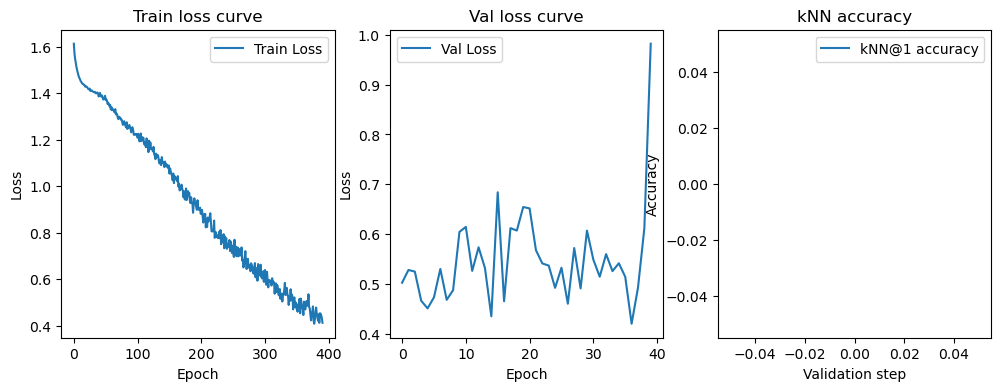

Epoch 2:   0%|          | 1/391 [00:04<26:36,  4.09s/it]

Epoch 2 Batch 0 Loss:0.4931
[diag] effK=2.57  sigma(mean/min/max)=0.352/0.0001/4.74  mse=0.216


Epoch 2:  13%|█▎        | 51/391 [02:57<19:40,  3.47s/it]

Epoch 2 Batch 50 Loss:0.3799


Epoch 2:  39%|███▊      | 151/391 [08:42<13:57,  3.49s/it]

Epoch 2 Batch 150 Loss:0.3150


Epoch 2:  51%|█████▏    | 201/391 [11:35<10:59,  3.47s/it]

Epoch 2 Batch 200 Loss:0.3396
[diag] effK=2.38  sigma(mean/min/max)=0.337/0.0001/5.06  mse=0.154


Epoch 2:  64%|██████▍   | 251/391 [14:27<08:02,  3.44s/it]

Epoch 2 Batch 250 Loss:0.2745


Epoch 2:  77%|███████▋  | 301/391 [17:20<05:11,  3.46s/it]

Epoch 2 Batch 300 Loss:0.2411


Epoch 2:  90%|████████▉ | 351/391 [20:14<02:18,  3.47s/it]

Epoch 2 Batch 350 Loss:0.2390


Epoch 2: 100%|██████████| 391/391 [22:30<00:00,  3.45s/it]


Validation kNN...
Epoch 2 kNN@1 accuracy: 4.50%


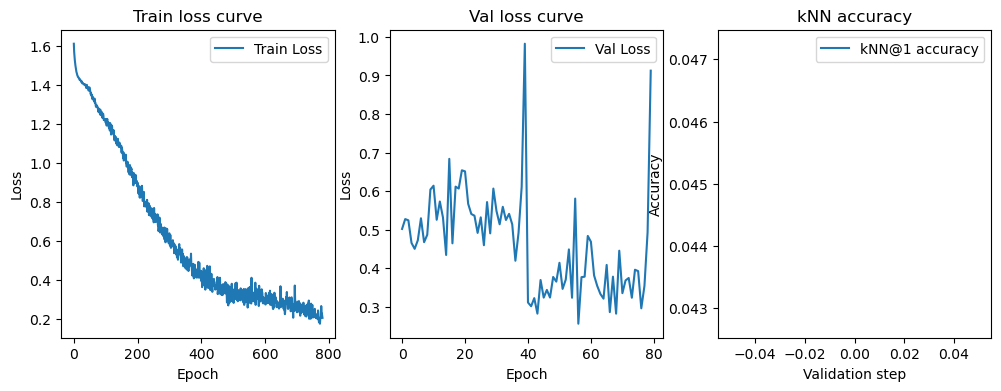

Epoch 3:   0%|          | 1/391 [00:04<27:09,  4.18s/it]

Epoch 3 Batch 0 Loss:0.2102
[diag] effK=2.21  sigma(mean/min/max)=0.318/0.0001/5.10  mse=0.117


Epoch 3:  26%|██▌       | 101/391 [05:51<16:36,  3.44s/it]

Epoch 3 Batch 100 Loss:0.1906


Epoch 3:  39%|███▊      | 151/391 [08:45<13:49,  3.46s/it]

Epoch 3 Batch 150 Loss:0.1385


Epoch 3:  51%|█████▏    | 201/391 [11:39<10:55,  3.45s/it]

Epoch 3 Batch 200 Loss:0.1254
[diag] effK=2.04  sigma(mean/min/max)=0.302/0.0001/5.72  mse=0.104


Epoch 3:  64%|██████▍   | 251/391 [14:33<08:04,  3.46s/it]

Epoch 3 Batch 250 Loss:0.1193


Epoch 3:  77%|███████▋  | 301/391 [17:26<05:18,  3.54s/it]

Epoch 3 Batch 300 Loss:0.0955


Epoch 3:  90%|████████▉ | 351/391 [20:21<02:18,  3.47s/it]

Epoch 3 Batch 350 Loss:0.1447


Epoch 3: 100%|██████████| 391/391 [22:38<00:00,  3.48s/it]


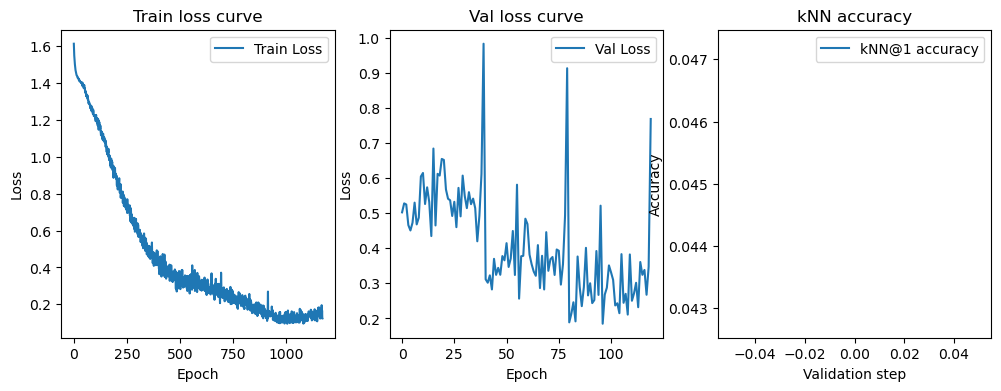

Epoch 4:   0%|          | 1/391 [00:04<28:23,  4.37s/it]

Epoch 4 Batch 0 Loss:0.1620
[diag] effK=1.90  sigma(mean/min/max)=0.301/0.0001/5.65  mse=0.102


Epoch 4:  13%|█▎        | 51/391 [02:58<19:57,  3.52s/it]

Epoch 4 Batch 50 Loss:0.1578


Epoch 4:  26%|██▌       | 101/391 [05:51<16:37,  3.44s/it]

Epoch 4 Batch 100 Loss:0.2244


Epoch 4:  39%|███▊      | 151/391 [08:44<13:43,  3.43s/it]

Epoch 4 Batch 150 Loss:0.1959


Epoch 4:  64%|██████▍   | 251/391 [14:31<08:04,  3.46s/it]

Epoch 4 Batch 250 Loss:0.2395


Epoch 4:  77%|███████▋  | 301/391 [17:25<05:13,  3.49s/it]

Epoch 4 Batch 300 Loss:0.2271


Epoch 4:  90%|████████▉ | 351/391 [20:17<02:16,  3.42s/it]

Epoch 4 Batch 350 Loss:0.2447


Epoch 4: 100%|██████████| 391/391 [22:34<00:00,  3.47s/it]


Validation kNN...
Epoch 4 kNN@1 accuracy: 5.60%


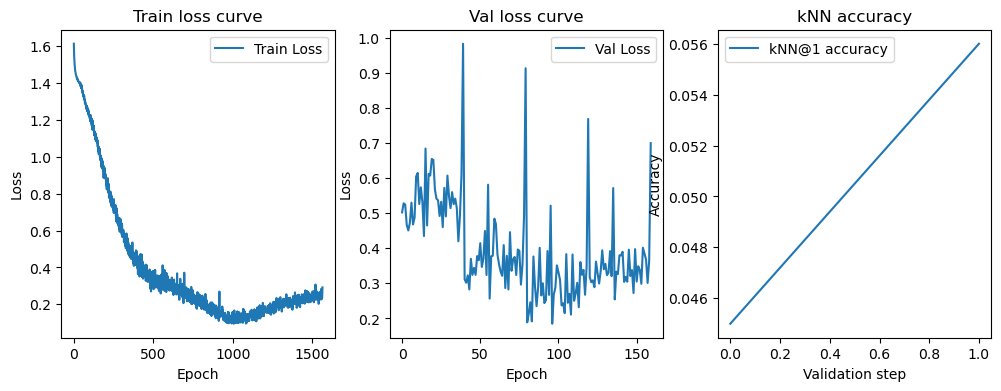

Epoch 5:   0%|          | 1/391 [00:04<29:16,  4.50s/it]

Epoch 5 Batch 0 Loss:0.2334
[diag] effK=1.73  sigma(mean/min/max)=0.334/0.0001/5.28  mse=0.107


Epoch 5:  13%|█▎        | 51/391 [02:57<19:26,  3.43s/it]

Epoch 5 Batch 50 Loss:0.2372


Epoch 5:  26%|██▌       | 101/391 [05:50<16:46,  3.47s/it]

Epoch 5 Batch 100 Loss:0.2545


Epoch 5:  51%|█████▏    | 201/391 [11:36<10:56,  3.45s/it]

Epoch 5 Batch 200 Loss:0.2367
[diag] effK=1.68  sigma(mean/min/max)=0.337/0.0001/4.24  mse=0.109


Epoch 5:  77%|███████▋  | 301/391 [17:22<05:14,  3.49s/it]

Epoch 5 Batch 300 Loss:0.2519


Epoch 5:  90%|████████▉ | 351/391 [20:15<02:16,  3.40s/it]

Epoch 5 Batch 350 Loss:0.2708


Epoch 5: 100%|██████████| 391/391 [22:32<00:00,  3.46s/it]


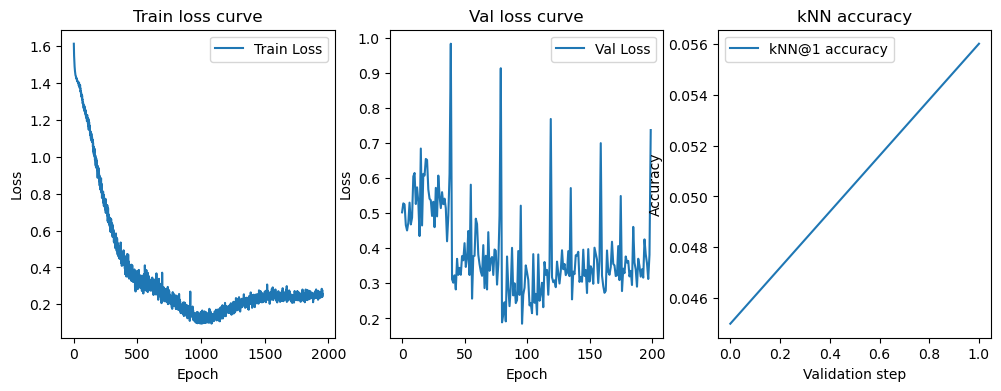

Epoch 6:   0%|          | 1/391 [00:04<28:03,  4.32s/it]

Epoch 6 Batch 0 Loss:0.2585
[diag] effK=1.66  sigma(mean/min/max)=0.335/0.0001/4.73  mse=0.113


Epoch 6:  13%|█▎        | 51/391 [02:57<19:47,  3.49s/it]

Epoch 6 Batch 50 Loss:0.2449


Epoch 6:  26%|██▌       | 101/391 [05:50<16:42,  3.46s/it]

Epoch 6 Batch 100 Loss:0.2584


Epoch 6:  39%|███▊      | 151/391 [08:44<13:59,  3.50s/it]

Epoch 6 Batch 150 Loss:0.2451


Epoch 6:  51%|█████▏    | 201/391 [11:37<10:57,  3.46s/it]

Epoch 6 Batch 200 Loss:0.2410
[diag] effK=1.64  sigma(mean/min/max)=0.338/0.0001/5.54  mse=0.110


Epoch 6:  64%|██████▍   | 251/391 [14:30<08:05,  3.47s/it]

Epoch 6 Batch 250 Loss:0.2754


Epoch 6:  77%|███████▋  | 301/391 [17:23<05:16,  3.51s/it]

Epoch 6 Batch 300 Loss:0.2649


Epoch 6:  90%|████████▉ | 351/391 [20:15<02:18,  3.47s/it]

Epoch 6 Batch 350 Loss:0.2173


Epoch 6: 100%|██████████| 391/391 [22:32<00:00,  3.46s/it]


Validation kNN...
Epoch 6 kNN@1 accuracy: 6.88%


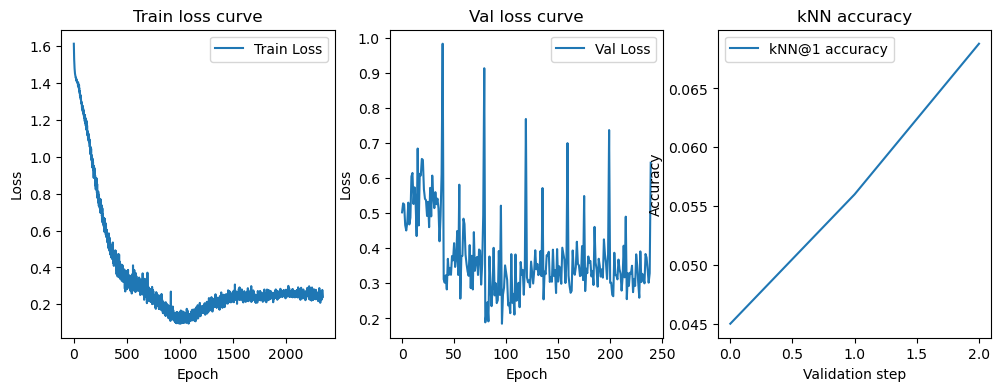

Epoch 7:   0%|          | 1/391 [00:04<26:42,  4.11s/it]

Epoch 7 Batch 0 Loss:0.2321
[diag] effK=1.63  sigma(mean/min/max)=0.343/0.0001/4.57  mse=0.106


Epoch 7:  13%|█▎        | 51/391 [02:56<19:31,  3.45s/it]

Epoch 7 Batch 50 Loss:0.2425


Epoch 7:  26%|██▌       | 101/391 [05:50<16:35,  3.43s/it]

Epoch 7 Batch 100 Loss:0.2363


Epoch 7:  39%|███▊      | 151/391 [08:44<13:40,  3.42s/it]

Epoch 7 Batch 150 Loss:0.2219


Epoch 7:  51%|█████▏    | 201/391 [11:37<10:50,  3.42s/it]

Epoch 7 Batch 200 Loss:0.2359
[diag] effK=1.62  sigma(mean/min/max)=0.337/0.0001/4.05  mse=0.108


Epoch 7:  64%|██████▍   | 251/391 [14:30<08:10,  3.50s/it]

Epoch 7 Batch 250 Loss:0.2433


Epoch 7:  90%|████████▉ | 351/391 [20:16<02:22,  3.55s/it]

Epoch 7 Batch 350 Loss:0.2248


Epoch 7: 100%|██████████| 391/391 [22:33<00:00,  3.46s/it]


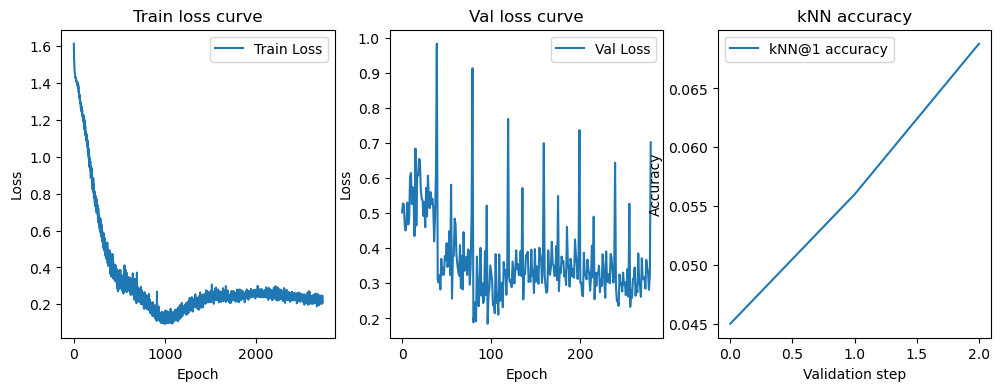

Epoch 8:   0%|          | 1/391 [00:04<28:15,  4.35s/it]

Epoch 8 Batch 0 Loss:0.2020
[diag] effK=1.62  sigma(mean/min/max)=0.336/0.0001/4.13  mse=0.100


Epoch 8:  13%|█▎        | 51/391 [02:57<19:52,  3.51s/it]

Epoch 8 Batch 50 Loss:0.2169


Epoch 8:  26%|██▌       | 101/391 [05:50<16:41,  3.45s/it]

Epoch 8 Batch 100 Loss:0.2100


Epoch 8:  39%|███▊      | 151/391 [08:44<13:56,  3.48s/it]

Epoch 8 Batch 150 Loss:0.2014


Epoch 8:  51%|█████▏    | 201/391 [11:37<10:57,  3.46s/it]

Epoch 8 Batch 200 Loss:0.2102
[diag] effK=1.61  sigma(mean/min/max)=0.330/0.0001/4.24  mse=0.101


Epoch 8:  64%|██████▍   | 251/391 [14:29<08:00,  3.44s/it]

Epoch 8 Batch 250 Loss:0.2267


Epoch 8:  77%|███████▋  | 301/391 [17:22<05:10,  3.45s/it]

Epoch 8 Batch 300 Loss:0.2110


Epoch 8:  90%|████████▉ | 351/391 [20:14<02:18,  3.45s/it]

Epoch 8 Batch 350 Loss:0.2160


Epoch 8: 100%|██████████| 391/391 [22:31<00:00,  3.46s/it]


Validation kNN...


Epoch 9:  13%|█▎        | 51/391 [02:56<19:35,  3.46s/it]

Epoch 9 Batch 50 Loss:0.2441


Epoch 9:  26%|██▌       | 101/391 [05:49<16:43,  3.46s/it]

Epoch 9 Batch 100 Loss:0.2349


Epoch 9:  39%|███▊      | 151/391 [08:43<14:02,  3.51s/it]

Epoch 9 Batch 150 Loss:0.2409


Epoch 9:  51%|█████▏    | 201/391 [11:35<10:52,  3.44s/it]

Epoch 9 Batch 200 Loss:0.2335
[diag] effK=1.61  sigma(mean/min/max)=0.336/0.0001/4.17  mse=0.106


Epoch 9:  64%|██████▍   | 251/391 [14:29<08:05,  3.47s/it]

Epoch 9 Batch 250 Loss:0.2567


Epoch 9:  77%|███████▋  | 301/391 [17:22<05:11,  3.46s/it]

Epoch 9 Batch 300 Loss:0.2622


Epoch 9:  90%|████████▉ | 351/391 [20:16<02:19,  3.49s/it]

Epoch 9 Batch 350 Loss:0.2602


Epoch 9: 100%|██████████| 391/391 [22:33<00:00,  3.46s/it]


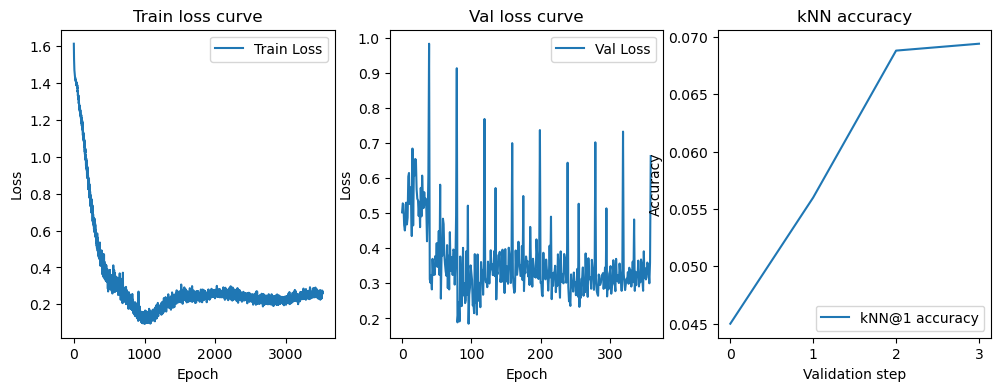

Epoch 10:   0%|          | 1/391 [00:04<29:06,  4.48s/it]

Epoch 10 Batch 0 Loss:0.2630
[diag] effK=1.61  sigma(mean/min/max)=0.340/0.0001/4.39  mse=0.110


Epoch 10:  13%|█▎        | 51/391 [02:57<19:22,  3.42s/it]

Epoch 10 Batch 50 Loss:0.2691


Epoch 10:  26%|██▌       | 101/391 [05:51<16:28,  3.41s/it]

Epoch 10 Batch 100 Loss:0.2595


Epoch 10:  39%|███▊      | 151/391 [08:44<13:43,  3.43s/it]

Epoch 10 Batch 150 Loss:0.2592


Epoch 10:  51%|█████▏    | 201/391 [11:37<10:52,  3.43s/it]

Epoch 10 Batch 200 Loss:0.2560
[diag] effK=1.60  sigma(mean/min/max)=0.342/0.0001/4.15  mse=0.111


Epoch 10:  64%|██████▍   | 251/391 [14:30<08:09,  3.50s/it]

Epoch 10 Batch 250 Loss:0.2404


Epoch 10:  77%|███████▋  | 301/391 [17:23<05:09,  3.44s/it]

Epoch 10 Batch 300 Loss:0.2387


Epoch 10:  90%|████████▉ | 351/391 [20:15<02:18,  3.45s/it]

Epoch 10 Batch 350 Loss:0.2108


Epoch 10: 100%|██████████| 391/391 [22:32<00:00,  3.46s/it]


Validation kNN...
Epoch 10 kNN@1 accuracy: 7.24%


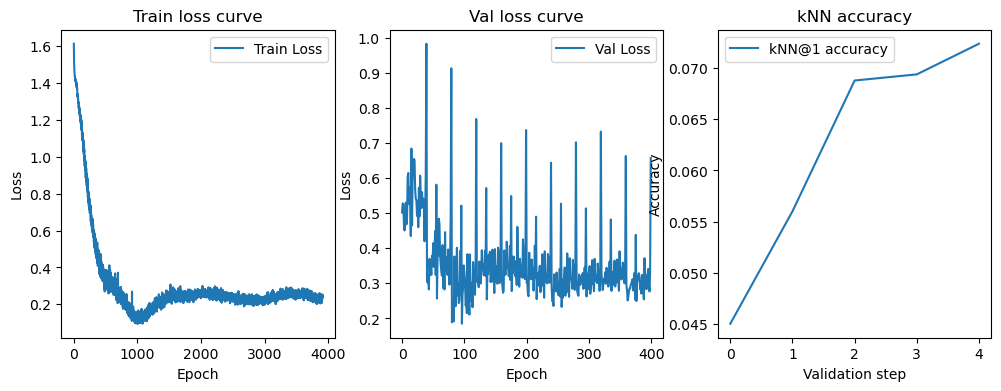

Epoch 11:   0%|          | 1/391 [00:04<26:48,  4.12s/it]

Epoch 11 Batch 0 Loss:0.2581
[diag] effK=1.60  sigma(mean/min/max)=0.343/0.0001/3.69  mse=0.111


Epoch 11:  13%|█▎        | 51/391 [02:57<19:26,  3.43s/it]

Epoch 11 Batch 50 Loss:0.2301


Epoch 11:  26%|██▌       | 101/391 [05:50<16:34,  3.43s/it]

Epoch 11 Batch 100 Loss:0.2142


Epoch 11:  39%|███▊      | 151/391 [08:43<14:07,  3.53s/it]

Epoch 11 Batch 150 Loss:0.2260


Epoch 11:  51%|█████▏    | 201/391 [11:37<11:05,  3.50s/it]

Epoch 11 Batch 200 Loss:0.2545
[diag] effK=1.60  sigma(mean/min/max)=0.334/0.0001/3.48  mse=0.110


Epoch 11:  64%|██████▍   | 251/391 [14:31<08:16,  3.55s/it]

Epoch 11 Batch 250 Loss:0.2289


Epoch 11:  77%|███████▋  | 301/391 [17:25<05:13,  3.49s/it]

Epoch 11 Batch 300 Loss:0.2062


Epoch 11:  90%|████████▉ | 351/391 [20:19<02:18,  3.46s/it]

Epoch 11 Batch 350 Loss:0.2239


Epoch 11: 100%|██████████| 391/391 [22:36<00:00,  3.47s/it]


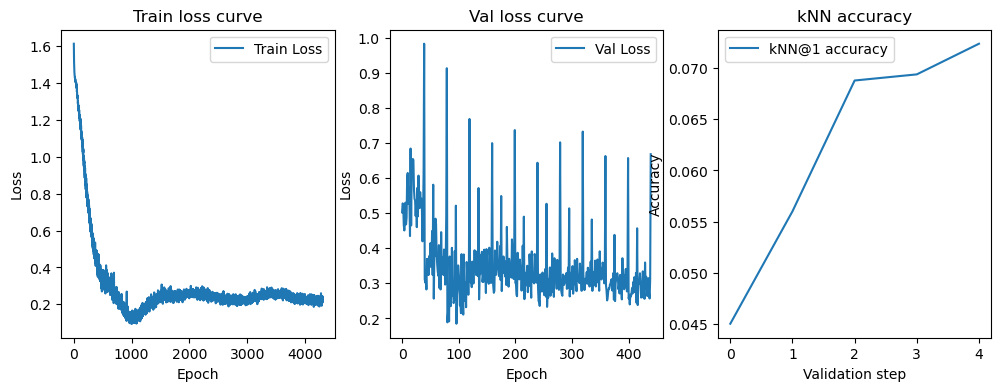

Epoch 12:   0%|          | 1/391 [00:04<26:58,  4.15s/it]

Epoch 12 Batch 0 Loss:0.2042
[diag] effK=1.60  sigma(mean/min/max)=0.335/0.0001/4.65  mse=0.103


Epoch 12:  13%|█▎        | 51/391 [02:57<19:57,  3.52s/it]

Epoch 12 Batch 50 Loss:0.2339


Epoch 12:  26%|██▌       | 101/391 [05:51<16:29,  3.41s/it]

Epoch 12 Batch 100 Loss:0.2094


Epoch 12:  39%|███▊      | 151/391 [08:44<13:41,  3.42s/it]

Epoch 12 Batch 150 Loss:0.2258


Epoch 12:  64%|██████▍   | 251/391 [14:29<08:09,  3.50s/it]

Epoch 12 Batch 250 Loss:0.1721


Epoch 12:  77%|███████▋  | 301/391 [17:23<05:15,  3.51s/it]

Epoch 12 Batch 300 Loss:0.2126


Epoch 12:  90%|████████▉ | 351/391 [20:16<02:19,  3.48s/it]

Epoch 12 Batch 350 Loss:0.1751


Epoch 12: 100%|██████████| 391/391 [22:33<00:00,  3.46s/it]


Validation kNN...
Epoch 12 kNN@1 accuracy: 7.58%


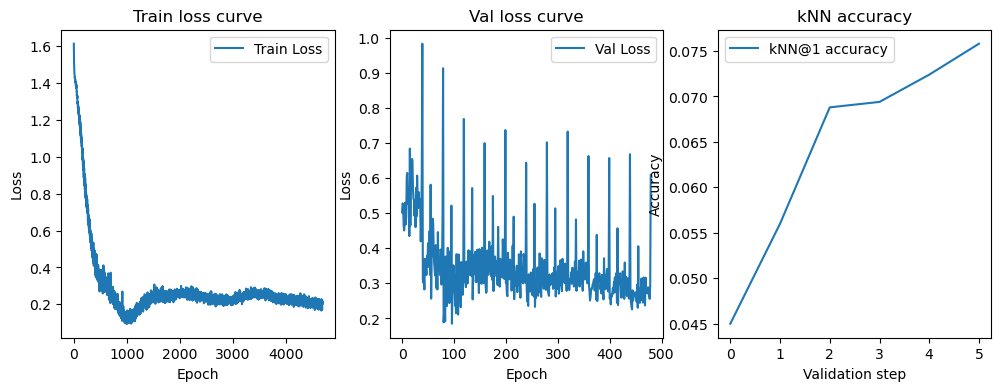

Epoch 13:   0%|          | 1/391 [00:04<26:24,  4.06s/it]

Epoch 13 Batch 0 Loss:0.2103
[diag] effK=1.60  sigma(mean/min/max)=0.336/0.0001/4.15  mse=0.103


Epoch 13:  13%|█▎        | 51/391 [02:58<19:50,  3.50s/it]

Epoch 13 Batch 50 Loss:0.1875


Epoch 13:  26%|██▌       | 101/391 [05:51<16:38,  3.44s/it]

Epoch 13 Batch 100 Loss:0.1884


Epoch 13:  39%|███▊      | 151/391 [08:44<13:50,  3.46s/it]

Epoch 13 Batch 150 Loss:0.1779


Epoch 13:  51%|█████▏    | 201/391 [11:36<11:03,  3.49s/it]

Epoch 13 Batch 200 Loss:0.1584
[diag] effK=1.60  sigma(mean/min/max)=0.326/0.0001/3.59  mse=0.095


Epoch 13:  64%|██████▍   | 251/391 [14:29<08:07,  3.48s/it]

Epoch 13 Batch 250 Loss:0.1726


Epoch 13:  77%|███████▋  | 301/391 [17:22<05:10,  3.45s/it]

Epoch 13 Batch 300 Loss:0.1786


Epoch 13:  90%|████████▉ | 351/391 [20:15<02:17,  3.44s/it]

Epoch 13 Batch 350 Loss:0.1358


Epoch 13: 100%|██████████| 391/391 [22:32<00:00,  3.46s/it]


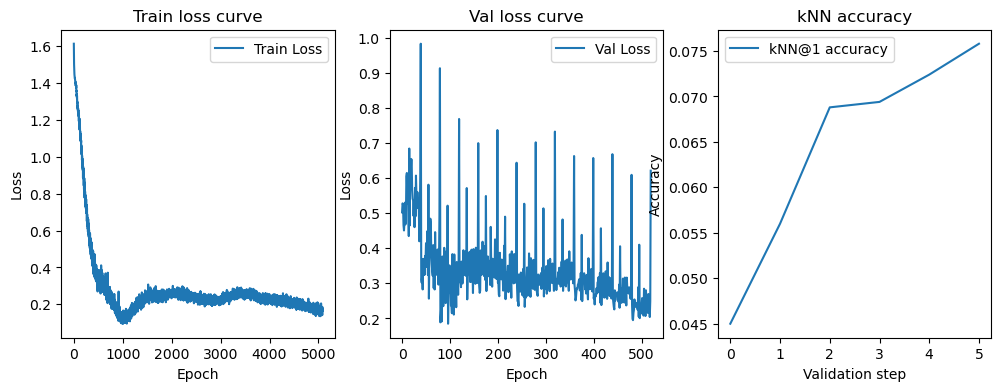

Epoch 14:   0%|          | 1/391 [00:04<27:01,  4.16s/it]

Epoch 14 Batch 0 Loss:0.1612
[diag] effK=1.60  sigma(mean/min/max)=0.327/0.0001/3.83  mse=0.097


Epoch 14:  13%|█▎        | 51/391 [02:57<19:37,  3.46s/it]

Epoch 14 Batch 50 Loss:0.1581


Epoch 14:  26%|██▌       | 101/391 [05:50<16:41,  3.45s/it]

Epoch 14 Batch 100 Loss:0.1675


Epoch 14:  39%|███▊      | 151/391 [08:44<13:49,  3.46s/it]

Epoch 14 Batch 150 Loss:0.1700


Epoch 14:  51%|█████▏    | 201/391 [11:37<11:05,  3.51s/it]

Epoch 14 Batch 200 Loss:0.1680
[diag] effK=1.60  sigma(mean/min/max)=0.328/0.0001/4.83  mse=0.100


Epoch 14:  64%|██████▍   | 251/391 [14:30<08:06,  3.47s/it]

Epoch 14 Batch 250 Loss:0.1568


Epoch 14:  77%|███████▋  | 301/391 [17:22<05:08,  3.43s/it]

Epoch 14 Batch 300 Loss:0.1597


Epoch 14:  90%|████████▉ | 351/391 [20:17<02:20,  3.51s/it]

Epoch 14 Batch 350 Loss:0.1479


Epoch 14: 100%|██████████| 391/391 [22:34<00:00,  3.46s/it]


Validation kNN...
Epoch 14 kNN@1 accuracy: 7.36%


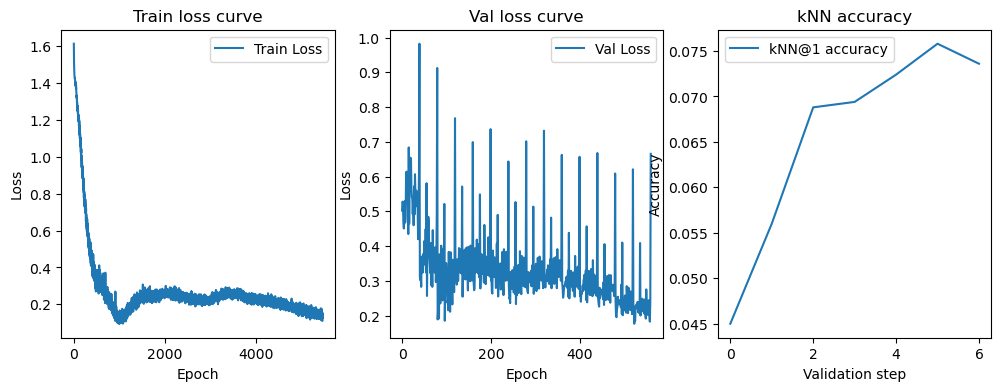

Epoch 15:   0%|          | 1/391 [00:04<29:12,  4.49s/it]

Epoch 15 Batch 0 Loss:0.1568
[diag] effK=1.60  sigma(mean/min/max)=0.324/0.0001/4.73  mse=0.095


Epoch 15:  13%|█▎        | 51/391 [02:57<19:31,  3.44s/it]

Epoch 15 Batch 50 Loss:0.1321


Epoch 15:  26%|██▌       | 101/391 [05:50<16:40,  3.45s/it]

Epoch 15 Batch 100 Loss:0.1343


Epoch 15:  39%|███▊      | 151/391 [08:43<14:00,  3.50s/it]

Epoch 15 Batch 150 Loss:0.1338


Epoch 15:  51%|█████▏    | 201/391 [11:36<10:58,  3.47s/it]

Epoch 15 Batch 200 Loss:0.1215
[diag] effK=1.60  sigma(mean/min/max)=0.314/0.0001/3.41  mse=0.091


Epoch 15:  64%|██████▍   | 251/391 [14:30<08:07,  3.49s/it]

Epoch 15 Batch 250 Loss:0.1132


Epoch 15:  77%|███████▋  | 301/391 [17:23<05:09,  3.44s/it]

Epoch 15 Batch 300 Loss:0.0923


Epoch 15:  90%|████████▉ | 351/391 [20:15<02:17,  3.43s/it]

Epoch 15 Batch 350 Loss:0.1059


Epoch 15: 100%|██████████| 391/391 [22:32<00:00,  3.46s/it]


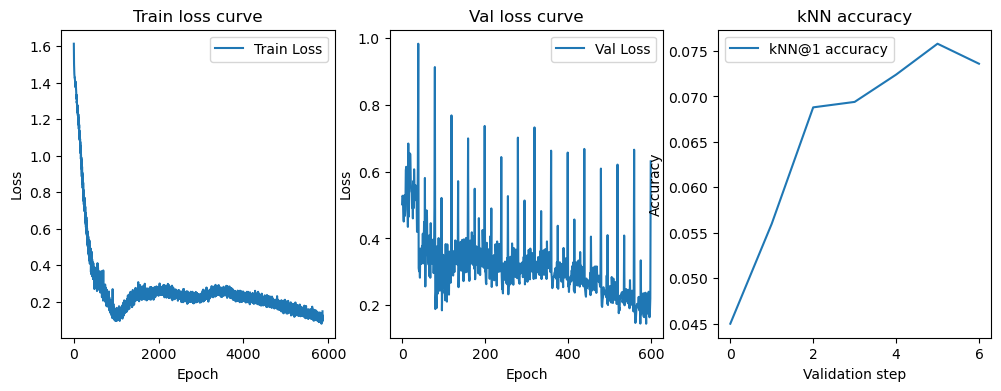

Epoch 16:   0%|          | 1/391 [00:04<29:22,  4.52s/it]

Epoch 16 Batch 0 Loss:0.1267
[diag] effK=1.60  sigma(mean/min/max)=0.324/0.0001/4.47  mse=0.092


Epoch 16:  13%|█▎        | 51/391 [02:57<19:37,  3.46s/it]

Epoch 16 Batch 50 Loss:0.1089


Epoch 16:  39%|███▊      | 151/391 [08:44<14:00,  3.50s/it]

Epoch 16 Batch 150 Loss:0.0983


Epoch 16:  51%|█████▏    | 201/391 [11:38<11:03,  3.49s/it]

Epoch 16 Batch 200 Loss:0.0799
[diag] effK=1.60  sigma(mean/min/max)=0.318/0.0001/5.43  mse=0.086


Epoch 16:  64%|██████▍   | 251/391 [14:31<08:10,  3.50s/it]

Epoch 16 Batch 250 Loss:0.0916


Epoch 16:  77%|███████▋  | 301/391 [17:25<05:11,  3.46s/it]

Epoch 16 Batch 300 Loss:0.0705


Epoch 16:  90%|████████▉ | 351/391 [20:18<02:21,  3.53s/it]

Epoch 16 Batch 350 Loss:0.1027


Epoch 16: 100%|██████████| 391/391 [22:36<00:00,  3.47s/it]


Validation kNN...
Epoch 16 kNN@1 accuracy: 7.92%


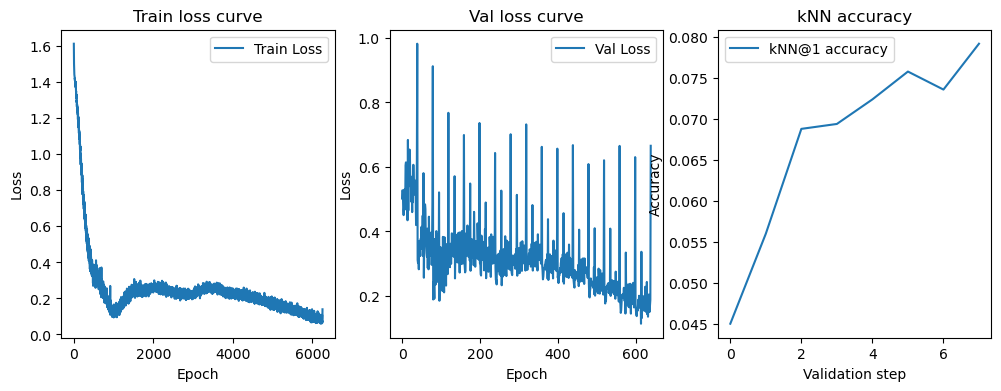

Epoch 17:   0%|          | 1/391 [00:04<26:23,  4.06s/it]

Epoch 17 Batch 0 Loss:0.0962
[diag] effK=1.60  sigma(mean/min/max)=0.313/0.0001/6.13  mse=0.089


Epoch 17:  13%|█▎        | 51/391 [02:57<19:35,  3.46s/it]

Epoch 17 Batch 50 Loss:0.0664


Epoch 17:  26%|██▌       | 101/391 [05:50<16:35,  3.43s/it]

Epoch 17 Batch 100 Loss:0.0571


Epoch 17:  39%|███▊      | 151/391 [08:44<13:46,  3.45s/it]

Epoch 17 Batch 150 Loss:0.0766


Epoch 17:  51%|█████▏    | 201/391 [11:36<11:04,  3.50s/it]

Epoch 17 Batch 200 Loss:0.0538
[diag] effK=1.60  sigma(mean/min/max)=0.315/0.0001/4.03  mse=0.083


Epoch 17:  64%|██████▍   | 251/391 [14:29<08:00,  3.43s/it]

Epoch 17 Batch 250 Loss:0.0405


Epoch 17:  77%|███████▋  | 301/391 [17:23<05:11,  3.46s/it]

Epoch 17 Batch 300 Loss:0.0544


Epoch 17:  90%|████████▉ | 351/391 [20:15<02:17,  3.45s/it]

Epoch 17 Batch 350 Loss:0.0250


Epoch 17: 100%|██████████| 391/391 [22:33<00:00,  3.46s/it]


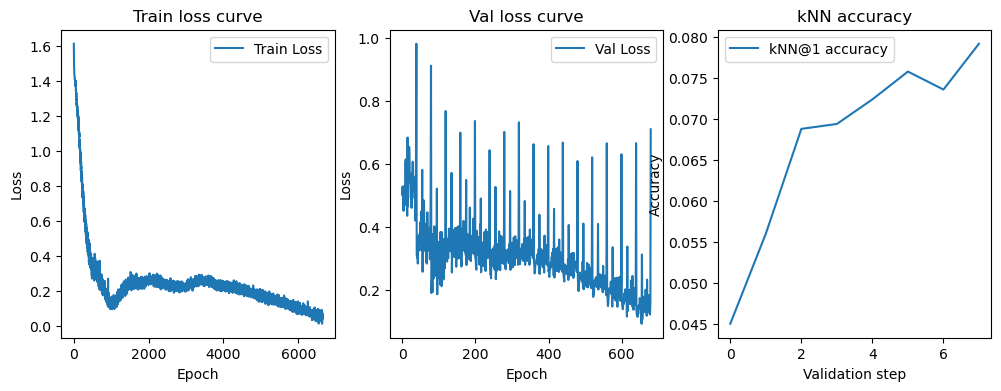

Epoch 18:   0%|          | 1/391 [00:04<28:05,  4.32s/it]

Epoch 18 Batch 0 Loss:0.0675
[diag] effK=1.60  sigma(mean/min/max)=0.313/0.0001/4.56  mse=0.084


Epoch 18:  13%|█▎        | 51/391 [02:57<19:35,  3.46s/it]

Epoch 18 Batch 50 Loss:0.0618


Epoch 18:  26%|██▌       | 101/391 [05:51<16:35,  3.43s/it]

Epoch 18 Batch 100 Loss:0.0522


Epoch 18:  39%|███▊      | 151/391 [08:42<13:46,  3.44s/it]

Epoch 18 Batch 150 Loss:0.0456


Epoch 18:  51%|█████▏    | 201/391 [11:34<10:46,  3.40s/it]

Epoch 18 Batch 200 Loss:0.0162
[diag] effK=1.60  sigma(mean/min/max)=0.311/0.0001/4.11  mse=0.079


Epoch 18:  64%|██████▍   | 251/391 [14:25<08:01,  3.44s/it]

Epoch 18 Batch 250 Loss:0.0309


Epoch 18:  77%|███████▋  | 301/391 [17:18<05:14,  3.50s/it]

Epoch 18 Batch 300 Loss:0.0296


Epoch 18:  90%|████████▉ | 351/391 [20:12<02:20,  3.52s/it]

Epoch 18 Batch 350 Loss:0.0249


Epoch 18: 100%|██████████| 391/391 [22:29<00:00,  3.45s/it]


Validation kNN...
Epoch 18 kNN@1 accuracy: 8.46%


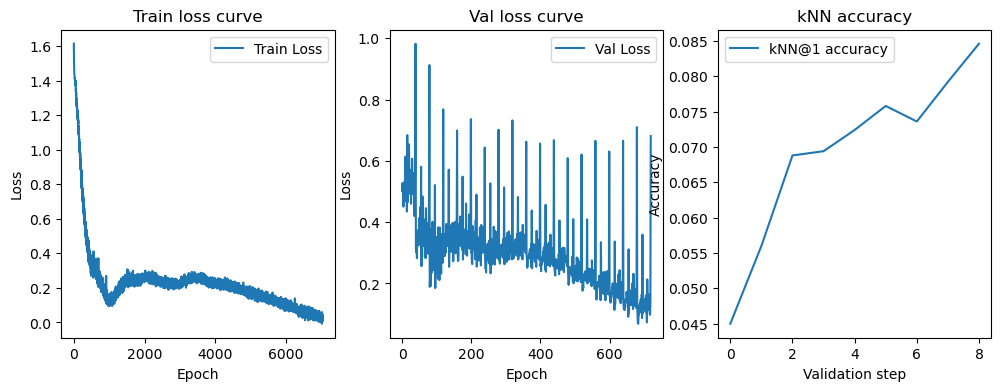

Epoch 19:   0%|          | 1/391 [00:04<27:17,  4.20s/it]

Epoch 19 Batch 0 Loss:0.0443
[diag] effK=1.60  sigma(mean/min/max)=0.309/0.0001/4.80  mse=0.084


Epoch 19:  13%|█▎        | 51/391 [02:57<19:43,  3.48s/it]

Epoch 19 Batch 50 Loss:0.0227


Epoch 19:  26%|██▌       | 101/391 [05:51<16:34,  3.43s/it]

Epoch 19 Batch 100 Loss:0.0056


Epoch 19:  39%|███▊      | 151/391 [08:45<13:59,  3.50s/it]

Epoch 19 Batch 150 Loss:0.0082


Epoch 19:  51%|█████▏    | 201/391 [11:39<11:11,  3.53s/it]

Epoch 19 Batch 200 Loss:0.0081
[diag] effK=1.60  sigma(mean/min/max)=0.303/0.0001/5.59  mse=0.079


Epoch 19:  64%|██████▍   | 251/391 [14:32<08:14,  3.53s/it]

Epoch 19 Batch 250 Loss:0.0447


Epoch 19:  77%|███████▋  | 301/391 [17:24<05:09,  3.44s/it]

Epoch 19 Batch 300 Loss:-0.0102


Epoch 19:  90%|████████▉ | 351/391 [20:18<02:16,  3.42s/it]

Epoch 19 Batch 350 Loss:0.0141


Epoch 19: 100%|██████████| 391/391 [22:35<00:00,  3.47s/it]


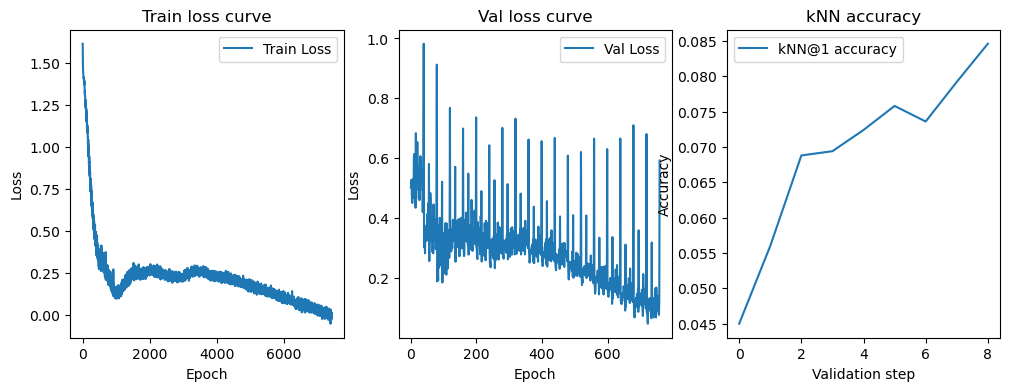

Epoch 20:   0%|          | 1/391 [00:04<26:00,  4.00s/it]

Epoch 20 Batch 0 Loss:0.0020
[diag] effK=1.60  sigma(mean/min/max)=0.303/0.0001/4.87  mse=0.078


Epoch 20:  13%|█▎        | 51/391 [02:57<19:46,  3.49s/it]

Epoch 20 Batch 50 Loss:-0.0334


Epoch 20:  26%|██▌       | 101/391 [05:50<16:44,  3.46s/it]

Epoch 20 Batch 100 Loss:-0.0191


Epoch 20:  39%|███▊      | 151/391 [08:43<13:58,  3.49s/it]

Epoch 20 Batch 150 Loss:-0.0406


Epoch 20:  51%|█████▏    | 201/391 [11:35<10:57,  3.46s/it]

Epoch 20 Batch 200 Loss:-0.0379
[diag] effK=1.60  sigma(mean/min/max)=0.299/0.0001/4.69  mse=0.073


Epoch 20:  64%|██████▍   | 251/391 [14:28<08:04,  3.46s/it]

Epoch 20 Batch 250 Loss:-0.0264


Epoch 20:  77%|███████▋  | 301/391 [17:21<05:07,  3.42s/it]

Epoch 20 Batch 300 Loss:-0.0337


Epoch 20:  90%|████████▉ | 351/391 [20:14<02:17,  3.44s/it]

Epoch 20 Batch 350 Loss:-0.0280


Epoch 20: 100%|██████████| 391/391 [22:32<00:00,  3.46s/it]


Validation kNN...
Epoch 20 kNN@1 accuracy: 8.40%


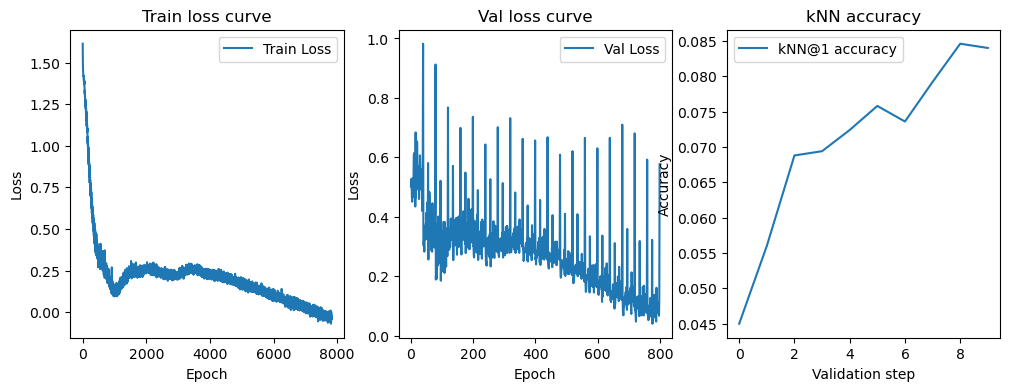

Epoch 21:   0%|          | 1/391 [00:04<28:18,  4.36s/it]

Epoch 21 Batch 0 Loss:-0.0236
[diag] effK=1.60  sigma(mean/min/max)=0.299/0.0001/4.54  mse=0.077


Epoch 21:  13%|█▎        | 51/391 [02:57<19:45,  3.49s/it]

Epoch 21 Batch 50 Loss:-0.0395


Epoch 21:  26%|██▌       | 101/391 [05:50<16:20,  3.38s/it]

Epoch 21 Batch 100 Loss:-0.0327


Epoch 21:  39%|███▊      | 151/391 [08:43<13:57,  3.49s/it]

Epoch 21 Batch 150 Loss:-0.0367


Epoch 21:  51%|█████▏    | 201/391 [11:35<10:51,  3.43s/it]

Epoch 21 Batch 200 Loss:-0.0316
[diag] effK=1.60  sigma(mean/min/max)=0.295/0.0001/4.43  mse=0.075


Epoch 21:  64%|██████▍   | 251/391 [14:28<08:04,  3.46s/it]

Epoch 21 Batch 250 Loss:-0.0435


Epoch 21:  77%|███████▋  | 301/391 [17:20<05:13,  3.48s/it]

Epoch 21 Batch 300 Loss:-0.0448


Epoch 21:  90%|████████▉ | 351/391 [20:13<02:20,  3.52s/it]

Epoch 21 Batch 350 Loss:-0.0584


Epoch 21: 100%|██████████| 391/391 [22:30<00:00,  3.45s/it]


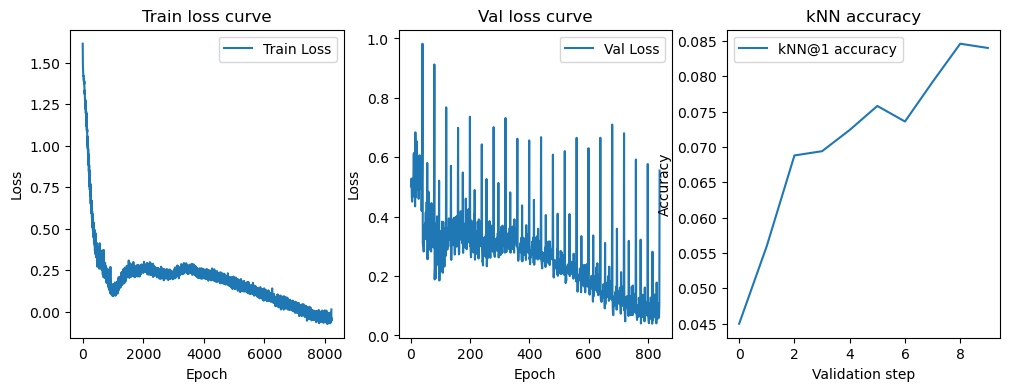

Epoch 22:   0%|          | 1/391 [00:04<28:20,  4.36s/it]

Epoch 22 Batch 0 Loss:-0.0178
[diag] effK=1.60  sigma(mean/min/max)=0.293/0.0001/3.85  mse=0.079


Epoch 22:  13%|█▎        | 51/391 [02:57<19:38,  3.46s/it]

Epoch 22 Batch 50 Loss:-0.0326


Epoch 22:  26%|██▌       | 101/391 [05:50<16:29,  3.41s/it]

Epoch 22 Batch 100 Loss:-0.0609


Epoch 22:  39%|███▊      | 151/391 [08:44<14:02,  3.51s/it]

Epoch 22 Batch 150 Loss:-0.0875


Epoch 22:  51%|█████▏    | 201/391 [11:37<10:47,  3.41s/it]

Epoch 22 Batch 200 Loss:-0.0798
[diag] effK=1.60  sigma(mean/min/max)=0.291/0.0001/4.36  mse=0.071


Epoch 22:  64%|██████▍   | 251/391 [14:30<08:03,  3.46s/it]

Epoch 22 Batch 250 Loss:-0.0638


Epoch 22:  77%|███████▋  | 301/391 [17:23<05:08,  3.43s/it]

Epoch 22 Batch 300 Loss:-0.0506


Epoch 22:  90%|████████▉ | 351/391 [20:17<02:19,  3.49s/it]

Epoch 22 Batch 350 Loss:-0.0386


Epoch 23:  13%|█▎        | 51/391 [02:57<19:59,  3.53s/it]]

Epoch 23 Batch 50 Loss:-0.0776


Epoch 23:  26%|██▌       | 101/391 [05:50<16:57,  3.51s/it]

Epoch 23 Batch 100 Loss:-0.0550


Epoch 23:  39%|███▊      | 151/391 [08:43<14:00,  3.50s/it]

Epoch 23 Batch 150 Loss:-0.0766


Epoch 23:  51%|█████▏    | 201/391 [11:37<10:57,  3.46s/it]

Epoch 23 Batch 200 Loss:-0.0783
[diag] effK=1.60  sigma(mean/min/max)=0.295/0.0001/5.98  mse=0.072


Epoch 23:  64%|██████▍   | 251/391 [14:31<08:03,  3.45s/it]

Epoch 23 Batch 250 Loss:-0.1048


Epoch 23:  77%|███████▋  | 301/391 [17:24<05:13,  3.48s/it]

Epoch 23 Batch 300 Loss:-0.0782


Epoch 23:  90%|████████▉ | 351/391 [20:17<02:17,  3.44s/it]

Epoch 23 Batch 350 Loss:-0.0861


Epoch 23: 100%|██████████| 391/391 [22:35<00:00,  3.47s/it]


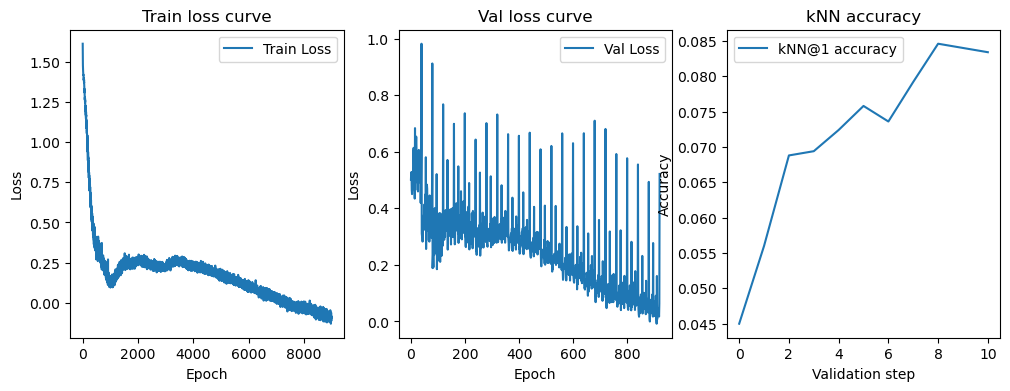

Epoch 24:   0%|          | 1/391 [00:04<26:05,  4.01s/it]

Epoch 24 Batch 0 Loss:-0.1209
[diag] effK=1.60  sigma(mean/min/max)=0.291/0.0001/5.25  mse=0.068


Epoch 24:  13%|█▎        | 51/391 [02:57<20:01,  3.53s/it]

Epoch 24 Batch 50 Loss:-0.1020


Epoch 24:  26%|██▌       | 101/391 [05:50<16:38,  3.44s/it]

Epoch 24 Batch 100 Loss:-0.0794


Epoch 24:  39%|███▊      | 151/391 [08:43<13:39,  3.42s/it]

Epoch 24 Batch 150 Loss:-0.0840


Epoch 24:  51%|█████▏    | 201/391 [11:35<10:58,  3.47s/it]

Epoch 24 Batch 200 Loss:-0.1282
[diag] effK=1.60  sigma(mean/min/max)=0.283/0.0001/6.83  mse=0.066


Epoch 24:  64%|██████▍   | 251/391 [14:27<07:57,  3.41s/it]

Epoch 24 Batch 250 Loss:-0.1134


Epoch 24:  77%|███████▋  | 301/391 [17:20<05:11,  3.46s/it]

Epoch 24 Batch 300 Loss:-0.1108


Epoch 24:  90%|████████▉ | 351/391 [20:13<02:19,  3.48s/it]

Epoch 24 Batch 350 Loss:-0.1373


Epoch 24: 100%|██████████| 391/391 [22:31<00:00,  3.46s/it]


Validation kNN...
Epoch 24 kNN@1 accuracy: 8.82%


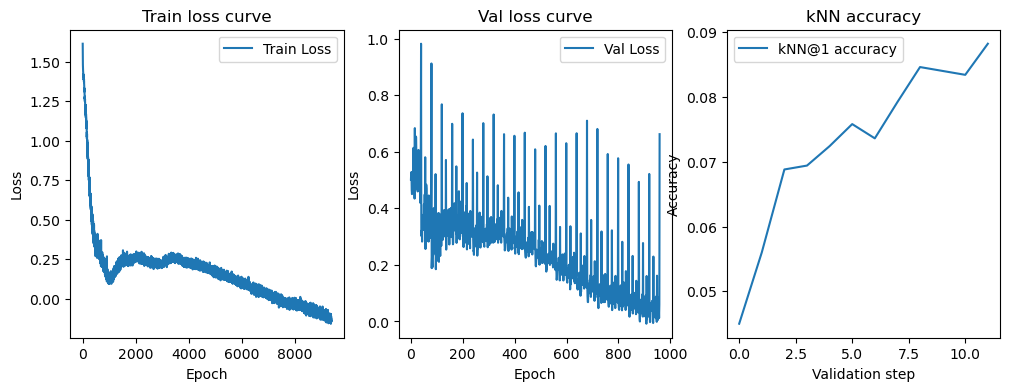

Epoch 25:   0%|          | 1/391 [00:04<27:40,  4.26s/it]

Epoch 25 Batch 0 Loss:-0.0983
[diag] effK=1.60  sigma(mean/min/max)=0.285/0.0001/6.47  mse=0.069


Epoch 25:  13%|█▎        | 51/391 [02:57<19:34,  3.45s/it]

Epoch 25 Batch 50 Loss:-0.1264


Epoch 25:  26%|██▌       | 101/391 [05:50<16:36,  3.43s/it]

Epoch 25 Batch 100 Loss:-0.1268


Epoch 25:  39%|███▊      | 151/391 [08:43<13:51,  3.47s/it]

Epoch 25 Batch 150 Loss:-0.1243


Epoch 25:  51%|█████▏    | 201/391 [11:35<10:59,  3.47s/it]

Epoch 25 Batch 200 Loss:-0.1454
[diag] effK=1.60  sigma(mean/min/max)=0.284/0.0001/8.14  mse=0.065


Epoch 25:  64%|██████▍   | 251/391 [14:29<08:12,  3.52s/it]

Epoch 25 Batch 250 Loss:-0.1406


Epoch 25:  77%|███████▋  | 301/391 [17:21<05:08,  3.43s/it]

Epoch 25 Batch 300 Loss:-0.1598


Epoch 25:  90%|████████▉ | 351/391 [20:14<02:18,  3.47s/it]

Epoch 25 Batch 350 Loss:-0.1484


Epoch 25: 100%|██████████| 391/391 [22:31<00:00,  3.46s/it]


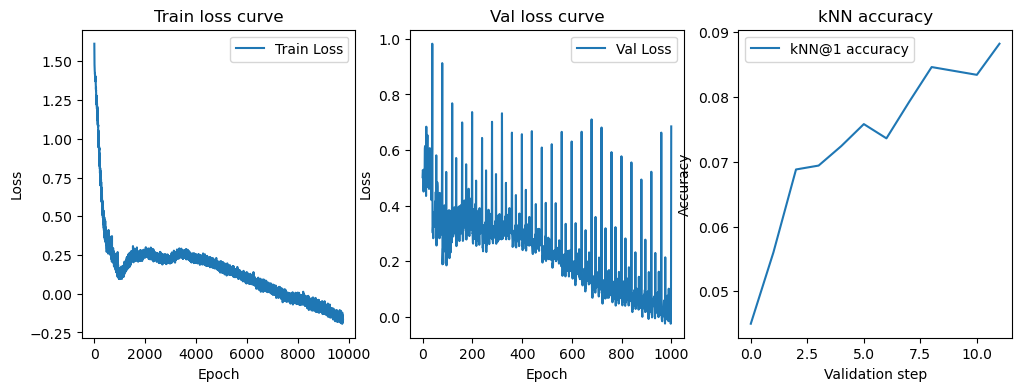

Epoch 26:   0%|          | 1/391 [00:04<27:27,  4.23s/it]

Epoch 26 Batch 0 Loss:-0.1624
[diag] effK=1.60  sigma(mean/min/max)=0.284/0.0001/7.60  mse=0.062


Epoch 26:  13%|█▎        | 51/391 [02:57<19:50,  3.50s/it]

Epoch 26 Batch 50 Loss:-0.1670


Epoch 26:  26%|██▌       | 101/391 [05:51<16:53,  3.49s/it]

Epoch 26 Batch 100 Loss:-0.1786


Epoch 26:  39%|███▊      | 151/391 [08:44<13:50,  3.46s/it]

Epoch 26 Batch 150 Loss:-0.1724


Epoch 26:  51%|█████▏    | 201/391 [11:38<11:01,  3.48s/it]

Epoch 26 Batch 200 Loss:-0.2152
[diag] effK=1.60  sigma(mean/min/max)=0.280/0.0001/6.72  mse=0.058


Epoch 26:  64%|██████▍   | 251/391 [14:31<07:58,  3.42s/it]

Epoch 26 Batch 250 Loss:-0.2040


Epoch 26:  77%|███████▋  | 301/391 [17:24<05:13,  3.48s/it]

Epoch 26 Batch 300 Loss:-0.1817


Epoch 26:  90%|████████▉ | 351/391 [20:18<02:19,  3.48s/it]

Epoch 26 Batch 350 Loss:-0.1955


Epoch 26: 100%|██████████| 391/391 [22:34<00:00,  3.46s/it]


Validation kNN...
Epoch 26 kNN@1 accuracy: 8.74%


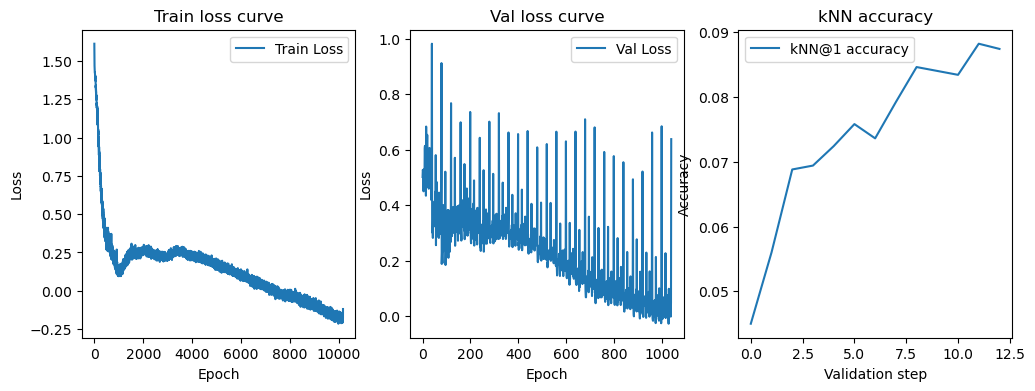

Epoch 27:   0%|          | 1/391 [00:04<27:54,  4.29s/it]

Epoch 27 Batch 0 Loss:-0.1796
[diag] effK=1.60  sigma(mean/min/max)=0.284/0.0001/6.94  mse=0.062


Epoch 27:  13%|█▎        | 51/391 [02:57<19:37,  3.46s/it]

Epoch 27 Batch 50 Loss:-0.1914


Epoch 27:  26%|██▌       | 101/391 [05:50<16:45,  3.47s/it]

Epoch 27 Batch 100 Loss:-0.1506


Epoch 27:  39%|███▊      | 151/391 [08:43<13:46,  3.45s/it]

Epoch 27 Batch 150 Loss:-0.2129


Epoch 27:  51%|█████▏    | 201/391 [11:35<10:59,  3.47s/it]

Epoch 27 Batch 200 Loss:-0.1931
[diag] effK=1.60  sigma(mean/min/max)=0.279/0.0001/7.13  mse=0.061


Epoch 27:  64%|██████▍   | 251/391 [14:27<07:59,  3.42s/it]

Epoch 27 Batch 250 Loss:-0.1700


Epoch 27:  77%|███████▋  | 301/391 [17:19<05:15,  3.50s/it]

Epoch 27 Batch 300 Loss:-0.2098


Epoch 27:  90%|████████▉ | 351/391 [20:13<02:18,  3.46s/it]

Epoch 27 Batch 350 Loss:-0.2063


Epoch 27: 100%|██████████| 391/391 [22:30<00:00,  3.45s/it]


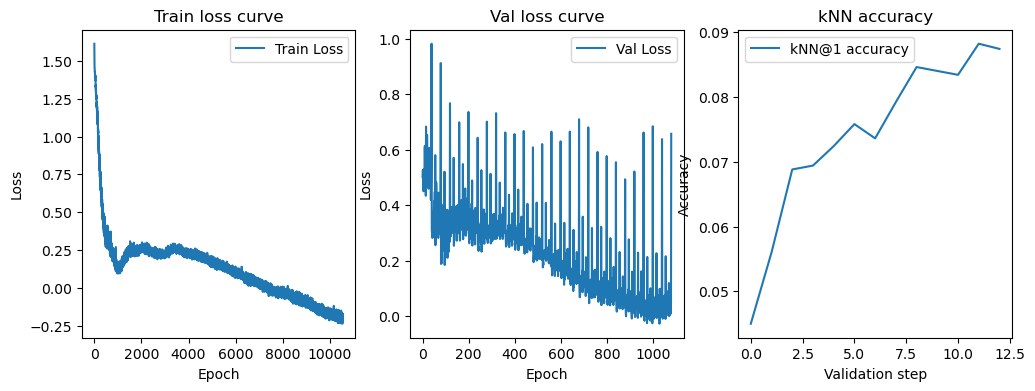

Epoch 28:   0%|          | 1/391 [00:04<27:53,  4.29s/it]

Epoch 28 Batch 0 Loss:-0.2155
[diag] effK=1.60  sigma(mean/min/max)=0.273/0.0001/6.33  mse=0.057


Epoch 28:  13%|█▎        | 51/391 [02:57<19:29,  3.44s/it]

Epoch 28 Batch 50 Loss:-0.2113


Epoch 28:  26%|██▌       | 101/391 [05:50<16:55,  3.50s/it]

Epoch 28 Batch 100 Loss:-0.2062


Epoch 28:  51%|█████▏    | 201/391 [11:37<10:47,  3.41s/it]

Epoch 28 Batch 200 Loss:-0.2326
[diag] effK=1.60  sigma(mean/min/max)=0.272/0.0001/6.08  mse=0.057


Epoch 28:  64%|██████▍   | 251/391 [14:29<07:59,  3.42s/it]

Epoch 28 Batch 250 Loss:-0.2214


Epoch 28:  77%|███████▋  | 301/391 [17:22<05:06,  3.40s/it]

Epoch 28 Batch 300 Loss:-0.1631


Epoch 28:  90%|████████▉ | 351/391 [20:16<02:20,  3.50s/it]

Epoch 28 Batch 350 Loss:-0.2216


Epoch 28: 100%|██████████| 391/391 [22:33<00:00,  3.46s/it]


Validation kNN...
Epoch 28 kNN@1 accuracy: 9.10%


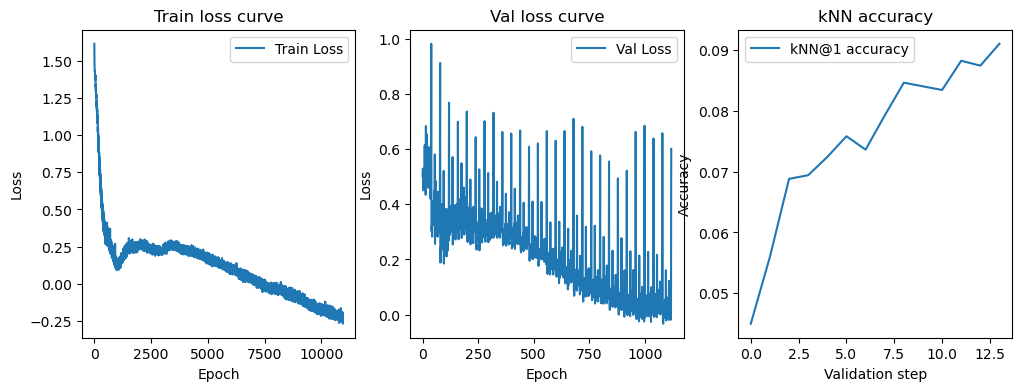

Epoch 29:   0%|          | 1/391 [00:04<27:23,  4.21s/it]

Epoch 29 Batch 0 Loss:-0.2296
[diag] effK=1.60  sigma(mean/min/max)=0.271/0.0001/5.41  mse=0.058


Epoch 29:  13%|█▎        | 51/391 [02:57<19:44,  3.48s/it]

Epoch 29 Batch 50 Loss:-0.2426


Epoch 29:  26%|██▌       | 101/391 [05:50<17:03,  3.53s/it]

Epoch 29 Batch 100 Loss:-0.2415


Epoch 29:  39%|███▊      | 151/391 [08:43<13:44,  3.44s/it]

Epoch 29 Batch 150 Loss:-0.2549


Epoch 29:  51%|█████▏    | 201/391 [11:36<10:59,  3.47s/it]

Epoch 29 Batch 200 Loss:-0.2338
[diag] effK=1.60  sigma(mean/min/max)=0.275/0.0001/4.33  mse=0.060


Epoch 29:  64%|██████▍   | 251/391 [14:29<07:59,  3.42s/it]

Epoch 29 Batch 250 Loss:-0.2287


Epoch 29:  77%|███████▋  | 301/391 [17:22<05:14,  3.49s/it]

Epoch 29 Batch 300 Loss:-0.2593


Epoch 29:  90%|████████▉ | 351/391 [20:15<02:18,  3.46s/it]

Epoch 29 Batch 350 Loss:-0.2561


Epoch 29: 100%|██████████| 391/391 [22:33<00:00,  3.46s/it]


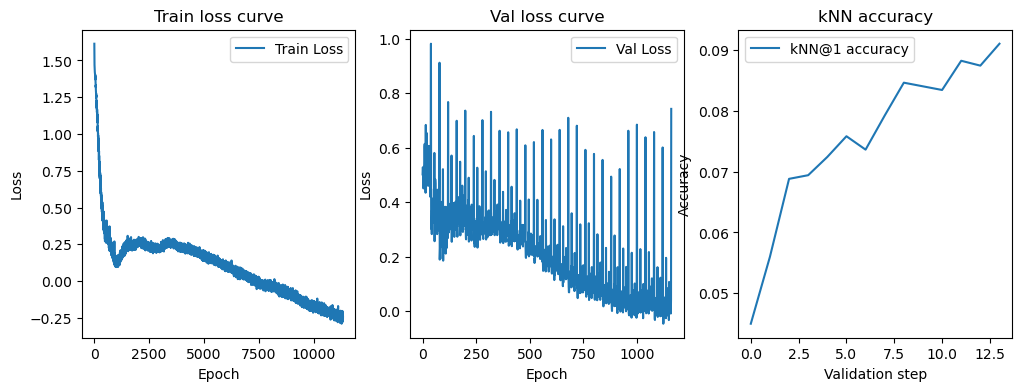

Epoch 30:   0%|          | 1/391 [00:04<27:51,  4.29s/it]

Epoch 30 Batch 0 Loss:-0.2598
[diag] effK=1.60  sigma(mean/min/max)=0.272/0.0001/7.40  mse=0.056


Epoch 30:  13%|█▎        | 51/391 [02:56<19:35,  3.46s/it]

Epoch 30 Batch 50 Loss:-0.2298


Epoch 30:  26%|██▌       | 101/391 [05:51<16:52,  3.49s/it]

Epoch 30 Batch 100 Loss:-0.2575


Epoch 30:  39%|███▊      | 151/391 [08:45<13:53,  3.47s/it]

Epoch 30 Batch 150 Loss:-0.2526


Epoch 30:  51%|█████▏    | 201/391 [11:38<11:07,  3.51s/it]

Epoch 30 Batch 200 Loss:-0.2509
[diag] effK=1.60  sigma(mean/min/max)=0.278/0.0001/9.01  mse=0.057


Epoch 30:  64%|██████▍   | 251/391 [14:32<08:05,  3.47s/it]

Epoch 30 Batch 250 Loss:-0.2147


Epoch 30:  77%|███████▋  | 301/391 [17:25<05:10,  3.45s/it]

Epoch 30 Batch 300 Loss:-0.2661


Epoch 30:  90%|████████▉ | 351/391 [20:18<02:17,  3.44s/it]

Epoch 30 Batch 350 Loss:-0.2702


Epoch 30: 100%|██████████| 391/391 [22:34<00:00,  3.46s/it]


Validation kNN...
Epoch 30 kNN@1 accuracy: 8.58%


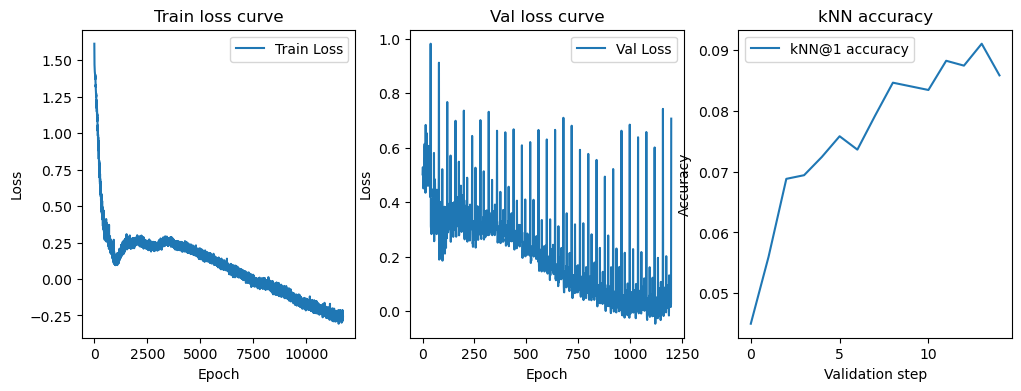

Training complete!


In [16]:
train_losses = []
val_losses = []
knn_accuracies = []

for epoch in range(EPOCHS):
    student.train()
    predictor.train()
    epoch_loss = 0
    
    for batch_idx, (x, _) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}")):
        x = x.to(DEVICE)
        B = x.size(0)
        grid = student.backbone.grid
        ctx_list, tgt_list = [], []
        
        # Sample masks
        for b in range(B):
            ctx_mask, tgt_mask = sample_context_and_targets(grid)
            ctx_list.append(ctx_mask)
            tgt_list.append(tgt_mask)
        context_mask = torch.stack(ctx_list, dim=0).to(x.device)
        target_mask = torch.stack(tgt_list, dim=0).to(x.device)
        
        # --- Encode context with student ---
        ctx_out, ctx_pad = student.encode_context(x, context_mask)  # (B, Sc, D)
        ctx_mask_float = (~ctx_pad).float().unsqueeze(-1)
        ctx_sum = (ctx_out * ctx_mask_float).sum(dim=1)
        ctx_count = ctx_mask_float.sum(dim=1).clamp(min=1)
        ctx_feat = ctx_sum / ctx_count  # (B, D)
        ctx_feat = F.layer_norm(ctx_feat, (ctx_feat.size(-1),))

        # --- Teacher target embeddings ---
        with torch.no_grad():
            t_tokens = teacher(x)  # (B, T, D)
        
        tgt_idxs = [target_mask[i].nonzero(as_tuple=False).squeeze(1) for i in range(B)]
        St = int(max([int(idx.numel()) for idx in tgt_idxs]) if tgt_idxs else 0)
        D = t_tokens.size(2)
        
        teacher_tgt = torch.zeros(B, St, D, device=x.device, dtype=t_tokens.dtype)
        tgt_pad = torch.ones(B, St, dtype=torch.bool, device=x.device)
        for i, idx in enumerate(tgt_idxs):
            L = int(idx.numel())
            if L == 0: continue
            teacher_tgt[i, :L] = t_tokens[i, idx]
            tgt_pad[i, :L] = False
        
        teacher_tgt_flat = teacher_tgt[~tgt_pad].view(-1, D)  # (BSt, D)
        
        # Normalize targets (optional but recommended)
        mean_tgt = teacher_tgt_flat.mean(dim=0, keepdim=True)
        std_tgt = teacher_tgt_flat.std(dim=0, keepdim=True) + 1e-8
        teacher_tgt_flat = (teacher_tgt_flat - mean_tgt) / std_tgt
        
        # Expand context for each target token
        num_tgt = teacher_tgt_flat.size(0)
        ctx_feat_expanded = ctx_feat.unsqueeze(1).expand(B, St, -1).reshape(B * St, -1)[~tgt_pad.view(-1)]
        
        # --- Predict mixture params conditioned on context ---
        alpha, mu, sigma = predictor(teacher_tgt_flat, ctx_feat_expanded)
        
        # --- NLL loss + regularization ---
        loss = mixture_gaussian_nll_loss(teacher_tgt_flat, alpha, mu, sigma)
        
        # В функции потерь ДОБАВЬ обратно:
        sigma_all = torch.cat([sigma[i].reshape(-1) for i in range(len(sigma))], dim=0)
        log_sigma_all = torch.log(sigma_all + 1e-8)
        
        # Регуляризация на РАЗНООБРАЗИЕ sigma (не на среднее!)
        log_sigma_mean = log_sigma_all.mean()
        log_sigma_std = log_sigma_all.std()
        
        # Штраф за слишком узкое распределение sigma
        sigma_diversity = 0.01 * (1.0 / (log_sigma_std + 0.1))
        
        # Штраф за слишком маленькие sigma
        sigma_floor = 0.005 * F.relu(math.log(0.05) - log_sigma_mean)
        
        loss = loss + sigma_diversity + sigma_floor


                
        # --- Backprop ---
        opt.zero_grad()
        loss.backward()
        opt.step()
        
        # EMA update teacher
        m = 0.996
        teacher.ema_update(student, m)
        
        if batch_idx % 50 == 0:
            print(f"Epoch {epoch+1} Batch {batch_idx} Loss:{loss.item():.4f}")
        train_losses.append(loss.item())

        if batch_idx % 200 == 0:
            with torch.no_grad():
                effK = torch.exp(-(alpha * (alpha+1e-10).log()).sum(dim=-1)).mean().item()
                sig_mean = sigma.mean().item()
                sig_min = sigma.min().item()
                sig_max = sigma.max().item()
                pred_mean = (alpha * mu).sum(dim=-1)     # (N_valid, D)
                mse_step = F.mse_loss(pred_mean, teacher_tgt_flat).item()
                print(f"[diag] effK={effK:.2f}  sigma(mean/min/max)={sig_mean:.3f}/{sig_min:.4f}/{sig_max:.2f}  mse={mse_step:.3f}")

    # avg_loss = epoch_loss / len(train_loader)
    # train_losses.append(avg_loss)
    
    val_loss_batches = eval_loss_on_loader(val_loader)
    val_losses.extend(val_loss_batches)
    
    # --- kNN Validation ---
    if (epoch + 1) % 2 == 0:
        print("Validation kNN...")
        tr_feats, tr_labels = extract_global_embeddings(student.backbone, train_loader, DEVICE)
        va_feats, va_labels = extract_global_embeddings(student.backbone, val_loader, DEVICE)
        knn_top1 = knn_eval(tr_feats, tr_labels, va_feats, va_labels, k=1)
        print(f"Epoch {epoch+1} kNN@1 accuracy: {knn_top1*100:.2f}%")
        
        knn_accuracies.append(knn_top1)
    
    # --- Plot ---
    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1)
    plt.plot(train_losses, label='Train Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Train loss curve')
    plt.subplot(1,3,2)
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Val loss curve')
    plt.subplot(1,3,3)
    plt.plot(knn_accuracies, label='kNN@1 accuracy')
    plt.xlabel('Validation step')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('kNN accuracy')
    plt.show()

print("Training complete!")

In [17]:
torch.save(student.state_dict(), "student_model.pth")
torch.save(predictor.state_dict(), "predictor_model.pth")
torch.save(teacher.state_dict(), "teacher_model.pth")

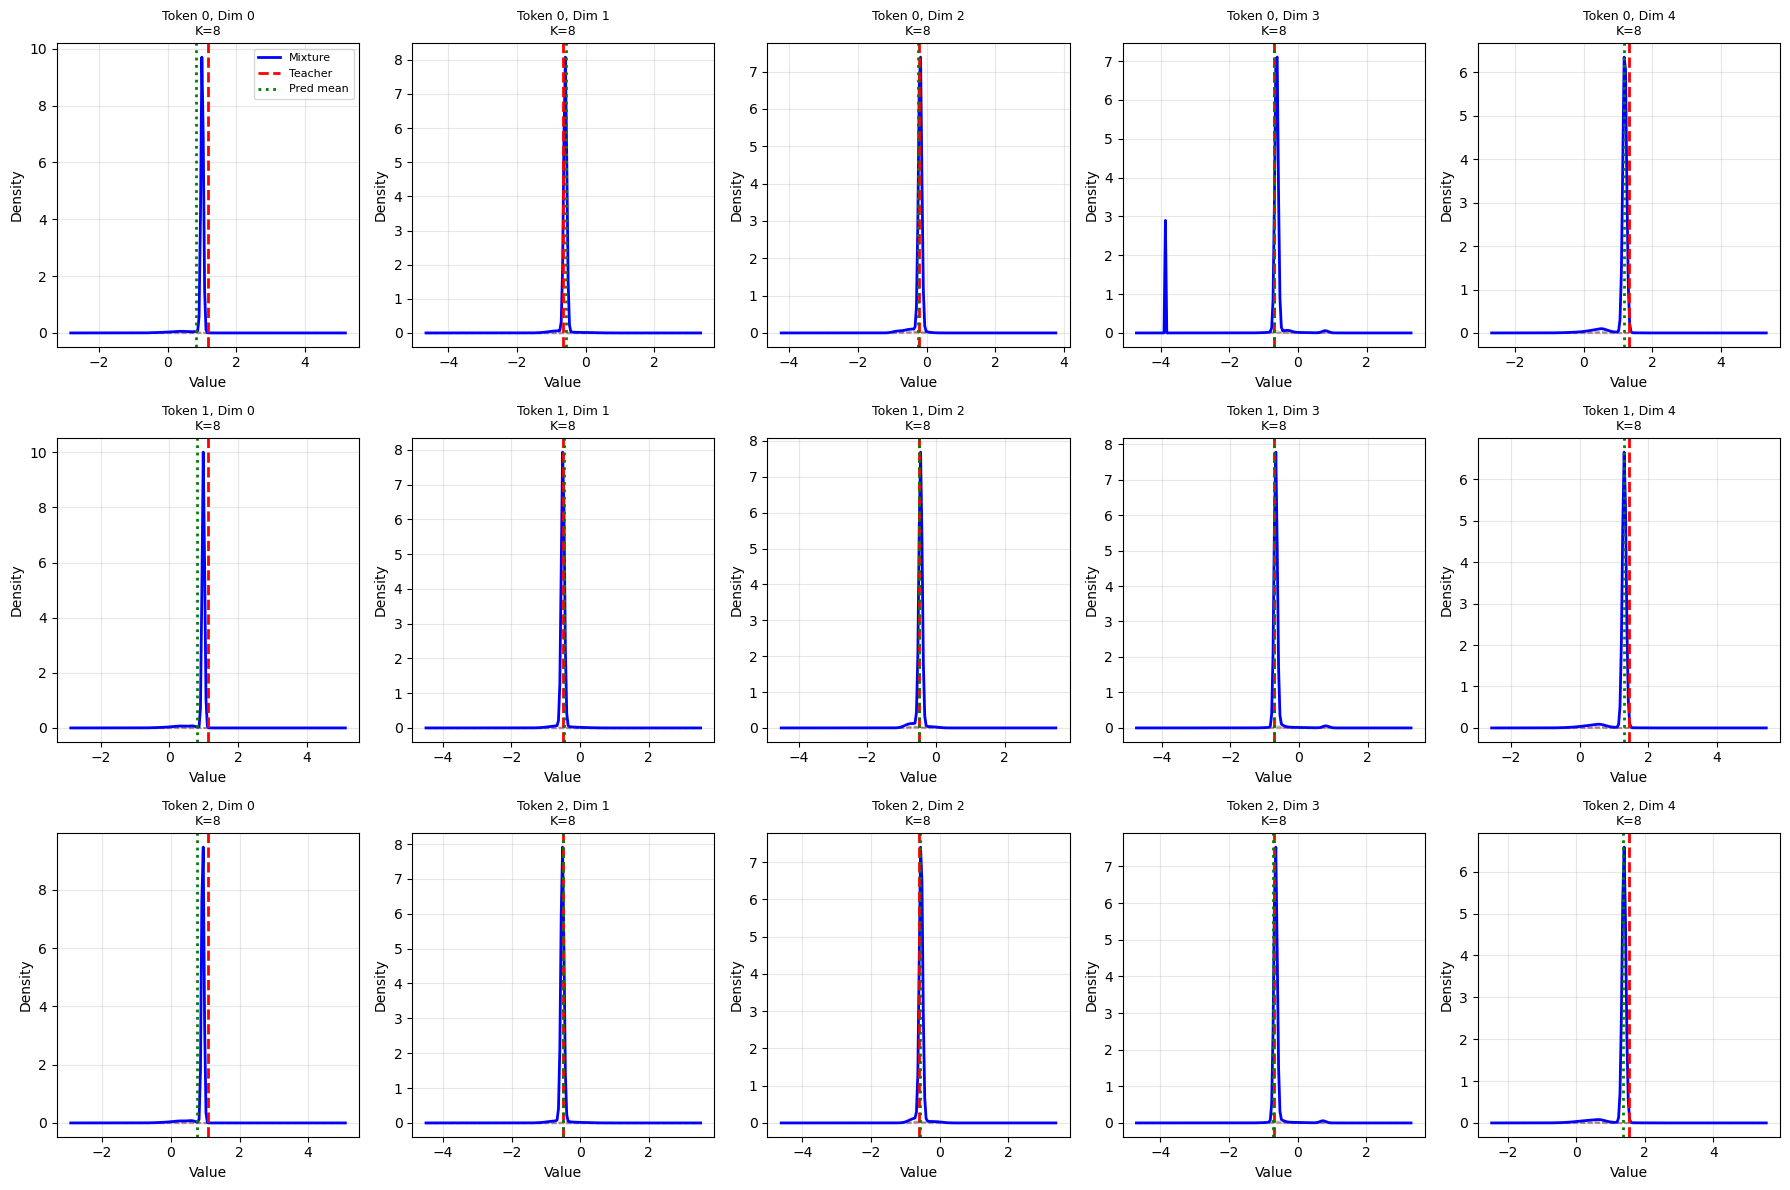


=== Статистика смеси гауссиан ===
Средний вес компонент (alpha): [0.13475688 0.1425104  0.1250766  0.12090099 0.12997639 0.12150756
 0.11728139 0.10855545]
Средняя сигма: 0.2778
Мин/Макс сигма: 0.0001 / 8.2765
Эффективное число компонент: 1.60 (из 8)
MSE (pred_mean vs teacher): 0.2692


In [18]:
# %% Визуализация распределений смеси гауссиан

import matplotlib.pyplot as plt
import seaborn as sns

@torch.no_grad()
def visualize_mixture_distributions(student, teacher, predictor, val_loader, device, num_examples=3):
    """
    Визуализирует распределения смеси гауссиан для нескольких примеров
    """
    student.eval()
    predictor.eval()
    
    # Берём один батч
    x, _ = next(iter(val_loader))
    x = x[:num_examples].to(device)
    B = x.size(0)
    grid = student.backbone.grid
    
    # Генерируем маски
    ctx_list, tgt_list = [], []
    for b in range(B):
        ctx_mask, tgt_mask = sample_context_and_targets(grid)
        ctx_list.append(ctx_mask)
        tgt_list.append(tgt_mask)
    context_mask = torch.stack(ctx_list, dim=0).to(x.device)
    target_mask = torch.stack(tgt_list, dim=0).to(x.device)
    
    # Encode context
    ctx_out, ctx_pad = student.encode_context(x, context_mask)
    ctx_mask_float = (~ctx_pad).float().unsqueeze(-1)
    ctx_sum = (ctx_out * ctx_mask_float).sum(dim=1)
    ctx_count = ctx_mask_float.sum(dim=1).clamp(min=1)
    ctx_feat = ctx_sum / ctx_count
    
    # Teacher targets
    t_tokens = teacher(x)
    tgt_idxs = [target_mask[i].nonzero(as_tuple=False).squeeze(1) for i in range(B)]
    St = int(max([int(idx.numel()) for idx in tgt_idxs]) if tgt_idxs else 0)
    D = t_tokens.size(2)
    
    teacher_tgt = torch.zeros(B, St, D, device=x.device, dtype=t_tokens.dtype)
    tgt_pad = torch.ones(B, St, dtype=torch.bool, device=x.device)
    for i, idx in enumerate(tgt_idxs):
        L = int(idx.numel())
        if L == 0: continue
        teacher_tgt[i, :L] = t_tokens[i, idx]
        tgt_pad[i, :L] = False
    
    teacher_tgt_flat = teacher_tgt[~tgt_pad].view(-1, D)
    mean_tgt = teacher_tgt_flat.mean(dim=0, keepdim=True)
    std_tgt = teacher_tgt_flat.std(dim=0, keepdim=True) + 1e-6
    teacher_tgt_flat = (teacher_tgt_flat - mean_tgt) / std_tgt
    
    # Expand context
    ctx_feat_expanded = ctx_feat.unsqueeze(1).expand(B, St, -1).reshape(B * St, -1)[~tgt_pad.view(-1)]
    
    # Predict
    alpha, mu, sigma = predictor(teacher_tgt_flat, ctx_feat_expanded)
    
    # Переведем на CPU для визуализации
    alpha_cpu = alpha.cpu().numpy()
    mu_cpu = mu.cpu().numpy()
    sigma_cpu = sigma.cpu().numpy()
    teacher_cpu = teacher_tgt_flat.cpu().numpy()
    
    # === Визуализация ===
    fig = plt.figure(figsize=(18, 4 * min(num_examples, 3)))
    
    # Берём первые несколько токенов для визуализации
    num_tokens_to_show = min(3, teacher_tgt_flat.size(0))
    
    for token_idx in range(num_tokens_to_show):
        # Выбираем первые 5 измерений для визуализации
        dims_to_show = min(5, D)
        
        for dim_idx in range(dims_to_show):
            plot_idx = token_idx * dims_to_show + dim_idx + 1
            ax = plt.subplot(num_tokens_to_show, dims_to_show, plot_idx)
            
            # Параметры смеси для этого токена и измерения
            alphas = alpha_cpu[token_idx, dim_idx]  # (K,)
            mus = mu_cpu[token_idx, dim_idx]        # (K,)
            sigmas = sigma_cpu[token_idx, dim_idx]  # (K,)
            target_val = teacher_cpu[token_idx, dim_idx]
            
            # Строим смесь гауссиан
            x_range = np.linspace(target_val - 4, target_val + 4, 200)
            mixture_pdf = np.zeros_like(x_range)
            
            # Каждая компонента смеси
            for k in range(len(alphas)):
                component_pdf = alphas[k] * np.exp(-0.5 * ((x_range - mus[k]) / sigmas[k])**2) / (sigmas[k] * np.sqrt(2 * np.pi))
                ax.plot(x_range, component_pdf, '--', alpha=0.3, linewidth=1)
                mixture_pdf += component_pdf
            
            # Итоговая смесь
            ax.plot(x_range, mixture_pdf, 'b-', linewidth=2, label='Mixture')
            
            # Истинное значение от teacher
            ax.axvline(target_val, color='r', linestyle='--', linewidth=2, label='Teacher')
            
            # Среднее предсказание (взвешенное среднее компонент)
            pred_mean = np.sum(alphas * mus)
            ax.axvline(pred_mean, color='g', linestyle=':', linewidth=2, label='Pred mean')
            
            ax.set_title(f'Token {token_idx}, Dim {dim_idx}\nK={len(alphas)}', fontsize=9)
            ax.set_xlabel('Value')
            ax.set_ylabel('Density')
            if plot_idx == 1:
                ax.legend(fontsize=8)
            ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('mixture_distributions.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    # === Статистика по компонентам ===
    print("\n=== Статистика смеси гауссиан ===")
    print(f"Средний вес компонент (alpha): {alpha_cpu.mean(axis=(0,1))}")
    print(f"Средняя сигма: {sigma_cpu.mean():.4f}")
    print(f"Мин/Макс сигма: {sigma_cpu.min():.4f} / {sigma_cpu.max():.4f}")
    
    # Эффективное число компонент (entropy-based)
    entropy = -np.sum(alpha_cpu * np.log(alpha_cpu + 1e-10), axis=-1)
    eff_components = np.exp(entropy)
    print(f"Эффективное число компонент: {eff_components.mean():.2f} (из {alpha_cpu.shape[-1]})")
    
    # Расстояние между предсказанием и teacher
    pred_means = (alpha_cpu * mu_cpu).sum(axis=-1)  # (N, D)
    mse = np.mean((pred_means - teacher_cpu)**2)
    print(f"MSE (pred_mean vs teacher): {mse:.4f}")
    
    return fig

# Запускаем визуализацию
fig = visualize_mixture_distributions(student, teacher, predictor, val_loader, DEVICE, num_examples=3)


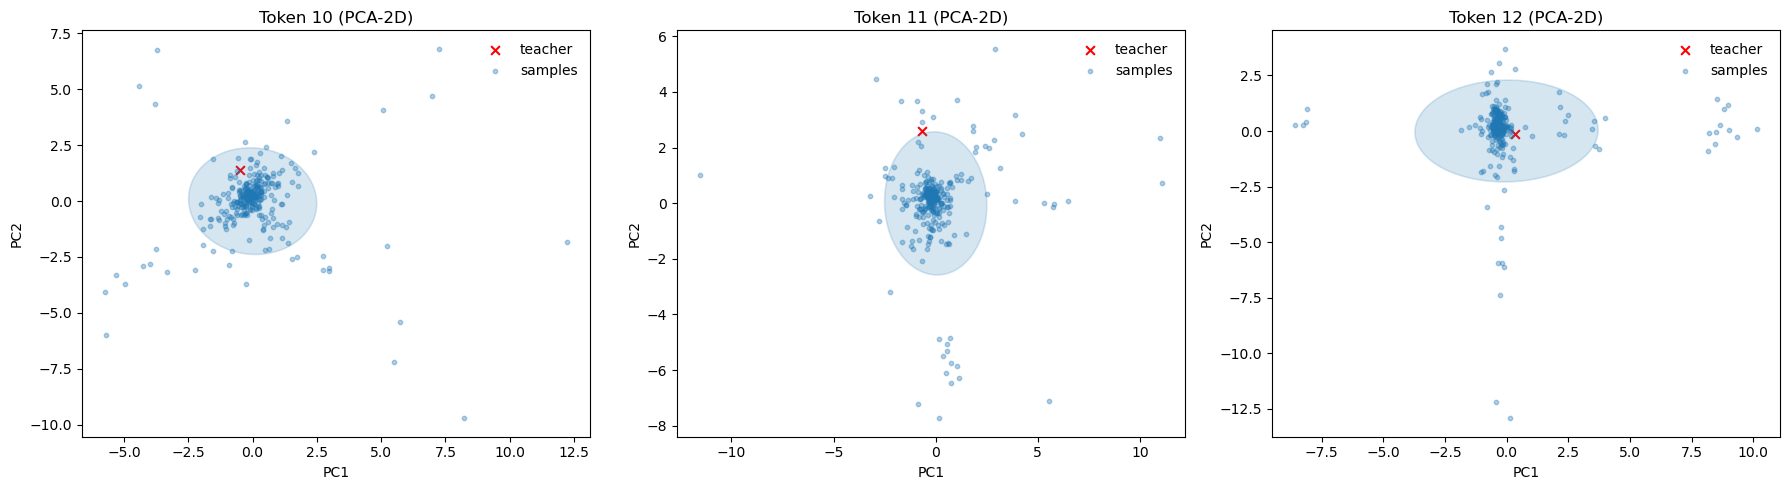

In [19]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

@torch.no_grad()
def _pca_per_token(X: torch.Tensor, p: int = 2):
    Xn = X.detach().cpu().float()
    mu = Xn.mean(dim=0, keepdim=True)
    Xc = Xn - mu
    U, S, Vt = torch.linalg.svd(Xc, full_matrices=False)
    P = Vt[:p].T  # (D, p)
    Z = Xc @ P    # (N, p)
    return Z.numpy(), P.numpy(), mu.squeeze(0).numpy()

def _add_cov_ellipse(ax, mean2d, cov2d, color='C0', alpha=0.25, nsig=2.0, lw=1.5):
    # eigendecomp
    vals, vecs = np.linalg.eigh(cov2d)
    order = vals.argsort()[::-1]
    vals, vecs = vals[order], vecs[:, order]
    theta = np.degrees(np.arctan2(*vecs[:, 0][::-1]))
    width, height = 2 * nsig * np.sqrt(np.maximum(vals, 1e-12))
    e = Ellipse(xy=mean2d, width=width, height=height, angle=theta,
                facecolor=color, edgecolor=color, alpha=alpha, lw=lw)
    ax.add_patch(e)

@torch.no_grad()
def visualize_token_mixture_pca2(
    student, teacher, predictor, val_loader, device,
    num_tokens=3, n_samples=300, seed=42, grid_res=120
):
    torch.manual_seed(seed); np.random.seed(seed)
    student.eval(); predictor.eval()

    x, _ = next(iter(val_loader))
    x = x[:1].to(device)
    grid = student.backbone.grid

    ctx_mask, tgt_mask = sample_context_and_targets(grid)
    context_mask = ctx_mask[None].to(device)
    target_mask  = tgt_mask[None].to(device)

    # контекст
    ctx_out, ctx_pad = student.encode_context(x, context_mask)
    ctx_mask_float = (~ctx_pad).float().unsqueeze(-1)
    ctx_feat = (ctx_out * ctx_mask_float).sum(dim=1) / ctx_mask_float.sum(dim=1).clamp(min=1)

    # teacher токены
    tt = teacher(x)  # (1, T, D)
    idx = target_mask[0].nonzero(as_tuple=False).squeeze(1)
    if idx.numel() == 0:
        print("No target tokens"); return
    idx = idx[:num_tokens]
    Tsel = idx.numel()
    D = tt.size(-1)

    teacher_sel = tt[0, idx]  # (Tsel, D)
    mean_tgt = teacher_sel.mean(dim=0, keepdim=True)
    std_tgt  = teacher_sel.std(dim=0, keepdim=True) + 1e-6
    teacher_norm = (teacher_sel - mean_tgt) / std_tgt

    # предсказанные параметры смеси
    ctx_exp = ctx_feat.expand(Tsel, -1)
    alpha, mu, sigma = predictor(teacher_norm, ctx_exp)  # (Tsel, D, K)

    # сэмплы в D
    N, K = Tsel, alpha.size(-1)
    comp = torch.multinomial(alpha.reshape(-1, K), num_samples=n_samples, replacement=True).reshape(N, D, n_samples)
    arN = torch.arange(N, device=device)[:, None, None]
    arD = torch.arange(D, device=device)[None, :, None]
    sel_mu = mu[arN, arD, comp]
    sel_sigma = sigma[arN, arD, comp]
    eps = torch.randn_like(sel_mu)
    samp = sel_mu + sel_sigma * eps   # (N, D, n_samples)
    samples = samp.permute(0, 2, 1).contiguous()  # (N, n_samples, D)

    # Рисуем по каждому токену свой PCA, обученный на teacher + его сэмплах
    cols = Tsel
    plt.figure(figsize=(6*cols, 5))
    for t in range(Tsel):
        Xt = torch.cat([teacher_norm[t:t+1], samples[t]], dim=0)  # (1+n_samples, D)
        Z, P, mu_p = _pca_per_token(Xt, p=2)  # (1+n_samples, 2)

        ax = plt.subplot(1, cols, t+1)
        # teacher
        ax.scatter(Z[0,0], Z[0,1], c='r', s=40, marker='x', label='teacher')
        # samples
        Zs = Z[1:]
        ax.scatter(Zs[:,0], Zs[:,1], c='C0', s=10, alpha=0.35, label='samples')

        # 2D ковариация в проекции (диагональная σ в D → ковариация в 2D = P^T diag(var) P)
        # оценим var по сэмплам
        var_d = samples[t].var(dim=0).cpu().numpy()  # (D,)
        P2 = P    # (D, 2)
        cov2 = (P2.T * var_d) @ P2   # (2,2)
        mean2 = Zs.mean(axis=0)
        _add_cov_ellipse(ax, mean2, cov2, color='C0', alpha=0.18, nsig=2.0, lw=1.2)

        # Теплокарта лог‑плотности смеси в проекции
        try:
            xlin = np.linspace(Z[:,0].min()-1.0, Z[:,0].max()+1.0, grid_res)
            ylin = np.linspace(Z[:,1].min()-1.0, Z[:,1].max()+1.0, grid_res)
            XX, YY = np.meshgrid(xlin, ylin)
            grid_pts = np.stack([XX.ravel(), YY.ravel()], axis=1)  # (G,2)
            # обратная проекция в D: approx x ≈ P @ z + mu_p
            Ztorch = torch.from_numpy(grid_pts).to(torch.float32)
            Ptorch = torch.from_numpy(P).to(torch.float32)
            mu_t = torch.from_numpy(mu_p).to(torch.float32)
            Xapprox = (Ztorch @ Ptorch.T) + mu_t  # (G, D)

            # плотность смеси (независимая по D)
            a = alpha[t].cpu().numpy()  # (D,K)
            m = mu[t].cpu().numpy()
            s = sigma[t].cpu().numpy()
            # лог-плотность p(x) = prod_d sum_k a_dk N(x_d|m_dk,s_dk)
            # считаем в логах и суммируем по d
            G = Xapprox.shape[0]
            logp = np.zeros(G, dtype=np.float32)
            for d in range(D):
                xd = Xapprox[:, d:d+1]   # (G,1)
                md = m[d]                # (K,)
                sd = s[d]                # (K,)
                # log sum exp по компонентам
                comp_log = (-np.log(sd+1e-8) - 0.5*np.log(2*np.pi) - 0.5*((xd - md)/(sd+1e-8))**2)  # (G,K)
                comp_log = np.log(a[d]+1e-8)[None,:] + comp_log
                # LSE по K
                maxl = comp_log.max(axis=1, keepdims=True)
                logp_d = maxl + np.log(np.exp(comp_log - maxl).sum(axis=1, keepdims=True)+1e-12)
                logp += logp_d.squeeze(1)
            # нормировка для визуализации
            logp_img = logp.reshape(grid_res, grid_res)
            ax.contourf(xlin, ylin, logp_img, levels=20, cmap='Blues', alpha=0.25)
        except Exception:
            pass

        ax.set_title(f"Token {int(idx[t].item())} (PCA-2D)")
        ax.set_xlabel("PC1"); ax.set_ylabel("PC2")
        ax.legend(frameon=False, loc='best')

    plt.tight_layout()
    plt.show()

# Вызов:
_ = visualize_token_mixture_pca2(
    student, teacher, predictor, 
    val_loader, DEVICE, 
    num_tokens=3, n_samples=300
)
